In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4014968, 832)
(4014968, 8)
validation
(782336, 832)
(782336, 8)
test
(325224, 832)
(325224, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1543048 (5.89 MB)


Trainable params: 1543048 (5.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/402 [..............................] - ETA: 8:29 - loss: 2.1565 - STD: 0.0569 - MAE: 0.2171

  5/402 [..............................] - ETA: 6s - loss: 2.0908 - STD: 0.0434 - MAE: 0.2169  

  9/402 [..............................] - ETA: 6s - loss: 2.0756 - STD: 0.0407 - MAE: 0.2167

 12/402 [..............................] - ETA: 6s - loss: 2.0699 - STD: 0.0393 - MAE: 0.2167

 16/402 [>.............................] - ETA: 6s - loss: 2.0622 - STD: 0.0378 - MAE: 0.2165

 19/402 [>.............................] - ETA: 6s - loss: 2.0544 - STD: 0.0374 - MAE: 0.2163

 23/402 [>.............................] - ETA: 6s - loss: 2.0417 - STD: 0.0372 - MAE: 0.2160

 27/402 [=>............................] - ETA: 6s - loss: 2.0243 - STD: 0.0395 - MAE: 0.2152

 31/402 [=>............................] - ETA: 6s - loss: 2.0069 - STD: 0.0435 - MAE: 0.2142

 35/402 [=>............................] - ETA: 6s - loss: 1.9899 - STD: 0.0472 - MAE: 0.2133

 39/402 [=>............................] - ETA: 5s - loss: 1.9723 - STD: 0.0502 - MAE: 0.2124

 43/402 [==>...........................] - ETA: 5s - loss: 1.9538 - STD: 0.0529 - MAE: 0.2115

 47/402 [==>...........................] - ETA: 5s - loss: 1.9356 - STD: 0.0557 - MAE: 0.2106

 51/402 [==>...........................] - ETA: 5s - loss: 1.9166 - STD: 0.0585 - MAE: 0.2096

 55/402 [===>..........................] - ETA: 5s - loss: 1.8973 - STD: 0.0615 - MAE: 0.2084

 59/402 [===>..........................] - ETA: 5s - loss: 1.8781 - STD: 0.0647 - MAE: 0.2073

 63/402 [===>..........................] - ETA: 5s - loss: 1.8599 - STD: 0.0679 - MAE: 0.2061

 67/402 [====>.........................] - ETA: 5s - loss: 1.8417 - STD: 0.0711 - MAE: 0.2049

 71/402 [====>.........................] - ETA: 5s - loss: 1.8246 - STD: 0.0740 - MAE: 0.2037

 75/402 [====>.........................] - ETA: 5s - loss: 1.8081 - STD: 0.0769 - MAE: 0.2026

 79/402 [====>.........................] - ETA: 5s - loss: 1.7927 - STD: 0.0796 - MAE: 0.2015

 83/402 [=====>........................] - ETA: 5s - loss: 1.7778 - STD: 0.0823 - MAE: 0.2005

 87/402 [=====>........................] - ETA: 5s - loss: 1.7635 - STD: 0.0848 - MAE: 0.1994

 91/402 [=====>........................] - ETA: 5s - loss: 1.7503 - STD: 0.0872 - MAE: 0.1985

 95/402 [======>.......................] - ETA: 4s - loss: 1.7376 - STD: 0.0895 - MAE: 0.1975

 99/402 [======>.......................] - ETA: 4s - loss: 1.7255 - STD: 0.0917 - MAE: 0.1966

103/402 [======>.......................] - ETA: 4s - loss: 1.7140 - STD: 0.0937 - MAE: 0.1957

107/402 [======>.......................] - ETA: 4s - loss: 1.7031 - STD: 0.0958 - MAE: 0.1949

111/402 [=======>......................] - ETA: 4s - loss: 1.6929 - STD: 0.0976 - MAE: 0.1941

115/402 [=======>......................] - ETA: 4s - loss: 1.6831 - STD: 0.0994 - MAE: 0.1934

119/402 [=======>......................] - ETA: 4s - loss: 1.6738 - STD: 0.1011 - MAE: 0.1926

123/402 [========>.....................] - ETA: 4s - loss: 1.6653 - STD: 0.1027 - MAE: 0.1920

127/402 [========>.....................] - ETA: 4s - loss: 1.6568 - STD: 0.1042 - MAE: 0.1913

131/402 [========>.....................] - ETA: 4s - loss: 1.6487 - STD: 0.1057 - MAE: 0.1907

135/402 [=========>....................] - ETA: 4s - loss: 1.6407 - STD: 0.1071 - MAE: 0.1900

139/402 [=========>....................] - ETA: 4s - loss: 1.6330 - STD: 0.1084 - MAE: 0.1894

143/402 [=========>....................] - ETA: 4s - loss: 1.6258 - STD: 0.1098 - MAE: 0.1889

147/402 [=========>....................] - ETA: 4s - loss: 1.6189 - STD: 0.1110 - MAE: 0.1883

151/402 [==========>...................] - ETA: 4s - loss: 1.6123 - STD: 0.1122 - MAE: 0.1878

155/402 [==========>...................] - ETA: 3s - loss: 1.6061 - STD: 0.1134 - MAE: 0.1872

159/402 [==========>...................] - ETA: 3s - loss: 1.6000 - STD: 0.1145 - MAE: 0.1868

163/402 [===========>..................] - ETA: 3s - loss: 1.5939 - STD: 0.1156 - MAE: 0.1863

167/402 [===========>..................] - ETA: 3s - loss: 1.5884 - STD: 0.1166 - MAE: 0.1858

171/402 [===========>..................] - ETA: 3s - loss: 1.5830 - STD: 0.1176 - MAE: 0.1854

175/402 [============>.................] - ETA: 3s - loss: 1.5779 - STD: 0.1186 - MAE: 0.1849

179/402 [============>.................] - ETA: 3s - loss: 1.5729 - STD: 0.1195 - MAE: 0.1845

183/402 [============>.................] - ETA: 3s - loss: 1.5679 - STD: 0.1205 - MAE: 0.1841

187/402 [============>.................] - ETA: 3s - loss: 1.5633 - STD: 0.1214 - MAE: 0.1837

191/402 [=============>................] - ETA: 3s - loss: 1.5586 - STD: 0.1222 - MAE: 0.1833

195/402 [=============>................] - ETA: 3s - loss: 1.5541 - STD: 0.1230 - MAE: 0.1829

199/402 [=============>................] - ETA: 3s - loss: 1.5498 - STD: 0.1238 - MAE: 0.1825

203/402 [==============>...............] - ETA: 3s - loss: 1.5454 - STD: 0.1246 - MAE: 0.1822

207/402 [==============>...............] - ETA: 3s - loss: 1.5412 - STD: 0.1253 - MAE: 0.1818

209/402 [==============>...............] - ETA: 3s - loss: 1.5396 - STD: 0.1257 - MAE: 0.1817

213/402 [==============>...............] - ETA: 3s - loss: 1.5356 - STD: 0.1264 - MAE: 0.1813

217/402 [===============>..............] - ETA: 3s - loss: 1.5318 - STD: 0.1271 - MAE: 0.1810

221/402 [===============>..............] - ETA: 3s - loss: 1.5280 - STD: 0.1278 - MAE: 0.1807

225/402 [===============>..............] - ETA: 3s - loss: 1.5243 - STD: 0.1285 - MAE: 0.1804

229/402 [================>.............] - ETA: 3s - loss: 1.5207 - STD: 0.1291 - MAE: 0.1800

233/402 [================>.............] - ETA: 3s - loss: 1.5171 - STD: 0.1298 - MAE: 0.1797

237/402 [================>.............] - ETA: 3s - loss: 1.5135 - STD: 0.1304 - MAE: 0.1794

241/402 [================>.............] - ETA: 3s - loss: 1.5100 - STD: 0.1310 - MAE: 0.1791

245/402 [=================>............] - ETA: 2s - loss: 1.5066 - STD: 0.1316 - MAE: 0.1789

249/402 [=================>............] - ETA: 2s - loss: 1.5031 - STD: 0.1322 - MAE: 0.1786

253/402 [=================>............] - ETA: 2s - loss: 1.4998 - STD: 0.1327 - MAE: 0.1783

257/402 [==================>...........] - ETA: 2s - loss: 1.4967 - STD: 0.1333 - MAE: 0.1780

261/402 [==================>...........] - ETA: 2s - loss: 1.4936 - STD: 0.1339 - MAE: 0.1777

265/402 [==================>...........] - ETA: 2s - loss: 1.4905 - STD: 0.1344 - MAE: 0.1775

269/402 [===================>..........] - ETA: 2s - loss: 1.4876 - STD: 0.1349 - MAE: 0.1772

273/402 [===================>..........] - ETA: 2s - loss: 1.4846 - STD: 0.1354 - MAE: 0.1770

277/402 [===================>..........] - ETA: 2s - loss: 1.4817 - STD: 0.1359 - MAE: 0.1767

281/402 [===================>..........] - ETA: 2s - loss: 1.4788 - STD: 0.1364 - MAE: 0.1765

285/402 [====================>.........] - ETA: 2s - loss: 1.4759 - STD: 0.1369 - MAE: 0.1762

289/402 [====================>.........] - ETA: 2s - loss: 1.4737 - STD: 0.1374 - MAE: 0.1760

293/402 [====================>.........] - ETA: 1s - loss: 1.4712 - STD: 0.1378 - MAE: 0.1758

297/402 [=====================>........] - ETA: 1s - loss: 1.4691 - STD: 0.1383 - MAE: 0.1756

301/402 [=====================>........] - ETA: 1s - loss: 1.4667 - STD: 0.1387 - MAE: 0.1754

305/402 [=====================>........] - ETA: 1s - loss: 1.4644 - STD: 0.1391 - MAE: 0.1752

309/402 [======================>.......] - ETA: 1s - loss: 1.4619 - STD: 0.1395 - MAE: 0.1750

313/402 [======================>.......] - ETA: 1s - loss: 1.4595 - STD: 0.1399 - MAE: 0.1748

317/402 [======================>.......] - ETA: 1s - loss: 1.4570 - STD: 0.1403 - MAE: 0.1746

321/402 [======================>.......] - ETA: 1s - loss: 1.4545 - STD: 0.1407 - MAE: 0.1744

325/402 [=======================>......] - ETA: 1s - loss: 1.4522 - STD: 0.1411 - MAE: 0.1741

329/402 [=======================>......] - ETA: 1s - loss: 1.4499 - STD: 0.1415 - MAE: 0.1740

333/402 [=======================>......] - ETA: 1s - loss: 1.4477 - STD: 0.1419 - MAE: 0.1738

337/402 [========================>.....] - ETA: 1s - loss: 1.4454 - STD: 0.1422 - MAE: 0.1736

341/402 [========================>.....] - ETA: 1s - loss: 1.4433 - STD: 0.1426 - MAE: 0.1734

345/402 [========================>.....] - ETA: 1s - loss: 1.4412 - STD: 0.1430 - MAE: 0.1732

348/402 [========================>.....] - ETA: 0s - loss: 1.4397 - STD: 0.1432 - MAE: 0.1731

352/402 [=========================>....] - ETA: 0s - loss: 1.4376 - STD: 0.1436 - MAE: 0.1729

356/402 [=========================>....] - ETA: 0s - loss: 1.4356 - STD: 0.1439 - MAE: 0.1727

360/402 [=========================>....] - ETA: 0s - loss: 1.4336 - STD: 0.1443 - MAE: 0.1725

364/402 [==========================>...] - ETA: 0s - loss: 1.4316 - STD: 0.1446 - MAE: 0.1723

368/402 [==========================>...] - ETA: 0s - loss: 1.4295 - STD: 0.1449 - MAE: 0.1722

371/402 [==========================>...] - ETA: 0s - loss: 1.4280 - STD: 0.1452 - MAE: 0.1720

375/402 [==========================>...] - ETA: 0s - loss: 1.4261 - STD: 0.1455 - MAE: 0.1719

379/402 [===========================>..] - ETA: 0s - loss: 1.4241 - STD: 0.1458 - MAE: 0.1717

383/402 [===========================>..] - ETA: 0s - loss: 1.4223 - STD: 0.1462 - MAE: 0.1715

387/402 [===========================>..] - ETA: 0s - loss: 1.4205 - STD: 0.1465 - MAE: 0.1714

391/402 [============================>.] - ETA: 0s - loss: 1.4187 - STD: 0.1468 - MAE: 0.1712

395/402 [============================>.] - ETA: 0s - loss: 1.4172 - STD: 0.1471 - MAE: 0.1711

399/402 [============================>.] - ETA: 0s - loss: 1.4154 - STD: 0.1474 - MAE: 0.1709

402/402 [==============================] - 10s 21ms/step - loss: 1.4140 - STD: 0.1476 - MAE: 0.1708 - val_loss: 1.4222 - val_STD: 0.1728 - val_MAE: 0.1645


Epoch 2/10000


  1/402 [..............................] - ETA: 17s - loss: 1.2528 - STD: 0.1758 - MAE: 0.1562

  4/402 [..............................] - ETA: 6s - loss: 1.2514 - STD: 0.1762 - MAE: 0.1561 

  8/402 [..............................] - ETA: 6s - loss: 1.2486 - STD: 0.1767 - MAE: 0.1558

 12/402 [..............................] - ETA: 6s - loss: 1.2476 - STD: 0.1766 - MAE: 0.1557

 15/402 [>.............................] - ETA: 6s - loss: 1.2501 - STD: 0.1764 - MAE: 0.1559

 18/402 [>.............................] - ETA: 6s - loss: 1.2500 - STD: 0.1761 - MAE: 0.1560

 21/402 [>.............................] - ETA: 6s - loss: 1.2482 - STD: 0.1761 - MAE: 0.1559

 24/402 [>.............................] - ETA: 6s - loss: 1.2476 - STD: 0.1762 - MAE: 0.1559

 27/402 [=>............................] - ETA: 6s - loss: 1.2453 - STD: 0.1762 - MAE: 0.1557

 30/402 [=>............................] - ETA: 6s - loss: 1.2444 - STD: 0.1764 - MAE: 0.1556

 33/402 [=>............................] - ETA: 6s - loss: 1.2429 - STD: 0.1766 - MAE: 0.1555

 36/402 [=>............................] - ETA: 6s - loss: 1.2413 - STD: 0.1769 - MAE: 0.1553

 39/402 [=>............................] - ETA: 6s - loss: 1.2394 - STD: 0.1770 - MAE: 0.1552

 43/402 [==>...........................] - ETA: 6s - loss: 1.2380 - STD: 0.1771 - MAE: 0.1551

 47/402 [==>...........................] - ETA: 5s - loss: 1.2365 - STD: 0.1773 - MAE: 0.1549

 50/402 [==>...........................] - ETA: 5s - loss: 1.2366 - STD: 0.1774 - MAE: 0.1549

 54/402 [===>..........................] - ETA: 5s - loss: 1.2364 - STD: 0.1775 - MAE: 0.1548

 58/402 [===>..........................] - ETA: 5s - loss: 1.2357 - STD: 0.1777 - MAE: 0.1548

 61/402 [===>..........................] - ETA: 5s - loss: 1.2352 - STD: 0.1778 - MAE: 0.1547

 64/402 [===>..........................] - ETA: 5s - loss: 1.2342 - STD: 0.1779 - MAE: 0.1546

 67/402 [====>.........................] - ETA: 5s - loss: 1.2332 - STD: 0.1780 - MAE: 0.1545

 70/402 [====>.........................] - ETA: 5s - loss: 1.2320 - STD: 0.1780 - MAE: 0.1544

 74/402 [====>.........................] - ETA: 5s - loss: 1.2309 - STD: 0.1781 - MAE: 0.1543

 78/402 [====>.........................] - ETA: 5s - loss: 1.2299 - STD: 0.1783 - MAE: 0.1543

 81/402 [=====>........................] - ETA: 5s - loss: 1.2294 - STD: 0.1783 - MAE: 0.1542

 85/402 [=====>........................] - ETA: 5s - loss: 1.2282 - STD: 0.1784 - MAE: 0.1541

 89/402 [=====>........................] - ETA: 5s - loss: 1.2271 - STD: 0.1785 - MAE: 0.1540

 93/402 [=====>........................] - ETA: 5s - loss: 1.2270 - STD: 0.1786 - MAE: 0.1540

 97/402 [======>.......................] - ETA: 5s - loss: 1.2260 - STD: 0.1787 - MAE: 0.1539

100/402 [======>.......................] - ETA: 5s - loss: 1.2255 - STD: 0.1788 - MAE: 0.1538

104/402 [======>.......................] - ETA: 4s - loss: 1.2249 - STD: 0.1789 - MAE: 0.1538

108/402 [=======>......................] - ETA: 4s - loss: 1.2240 - STD: 0.1789 - MAE: 0.1537

112/402 [=======>......................] - ETA: 4s - loss: 1.2233 - STD: 0.1790 - MAE: 0.1537

116/402 [=======>......................] - ETA: 4s - loss: 1.2224 - STD: 0.1791 - MAE: 0.1536

120/402 [=======>......................] - ETA: 4s - loss: 1.2215 - STD: 0.1792 - MAE: 0.1535

124/402 [========>.....................] - ETA: 4s - loss: 1.2204 - STD: 0.1793 - MAE: 0.1534

128/402 [========>.....................] - ETA: 4s - loss: 1.2195 - STD: 0.1795 - MAE: 0.1533

131/402 [========>.....................] - ETA: 4s - loss: 1.2193 - STD: 0.1796 - MAE: 0.1533

135/402 [=========>....................] - ETA: 4s - loss: 1.2184 - STD: 0.1796 - MAE: 0.1532

139/402 [=========>....................] - ETA: 4s - loss: 1.2179 - STD: 0.1797 - MAE: 0.1531

143/402 [=========>....................] - ETA: 4s - loss: 1.2171 - STD: 0.1798 - MAE: 0.1531

146/402 [=========>....................] - ETA: 4s - loss: 1.2164 - STD: 0.1799 - MAE: 0.1530

150/402 [==========>...................] - ETA: 4s - loss: 1.2155 - STD: 0.1800 - MAE: 0.1529

154/402 [==========>...................] - ETA: 4s - loss: 1.2147 - STD: 0.1801 - MAE: 0.1528

158/402 [==========>...................] - ETA: 4s - loss: 1.2139 - STD: 0.1802 - MAE: 0.1528

162/402 [===========>..................] - ETA: 3s - loss: 1.2132 - STD: 0.1803 - MAE: 0.1527

166/402 [===========>..................] - ETA: 3s - loss: 1.2124 - STD: 0.1804 - MAE: 0.1526

170/402 [===========>..................] - ETA: 3s - loss: 1.2117 - STD: 0.1805 - MAE: 0.1526

174/402 [===========>..................] - ETA: 3s - loss: 1.2109 - STD: 0.1806 - MAE: 0.1525

178/402 [============>.................] - ETA: 3s - loss: 1.2099 - STD: 0.1807 - MAE: 0.1524

182/402 [============>.................] - ETA: 3s - loss: 1.2091 - STD: 0.1808 - MAE: 0.1523

186/402 [============>.................] - ETA: 3s - loss: 1.2085 - STD: 0.1809 - MAE: 0.1523

190/402 [=============>................] - ETA: 3s - loss: 1.2078 - STD: 0.1810 - MAE: 0.1522

194/402 [=============>................] - ETA: 3s - loss: 1.2072 - STD: 0.1811 - MAE: 0.1521

198/402 [=============>................] - ETA: 3s - loss: 1.2068 - STD: 0.1812 - MAE: 0.1521

202/402 [==============>...............] - ETA: 3s - loss: 1.2064 - STD: 0.1813 - MAE: 0.1520

205/402 [==============>...............] - ETA: 3s - loss: 1.2063 - STD: 0.1813 - MAE: 0.1520

209/402 [==============>...............] - ETA: 3s - loss: 1.2063 - STD: 0.1814 - MAE: 0.1520

213/402 [==============>...............] - ETA: 3s - loss: 1.2060 - STD: 0.1815 - MAE: 0.1519

217/402 [===============>..............] - ETA: 3s - loss: 1.2054 - STD: 0.1815 - MAE: 0.1519

221/402 [===============>..............] - ETA: 2s - loss: 1.2050 - STD: 0.1816 - MAE: 0.1518

225/402 [===============>..............] - ETA: 2s - loss: 1.2043 - STD: 0.1817 - MAE: 0.1518

229/402 [================>.............] - ETA: 2s - loss: 1.2037 - STD: 0.1817 - MAE: 0.1517

233/402 [================>.............] - ETA: 2s - loss: 1.2031 - STD: 0.1818 - MAE: 0.1517

237/402 [================>.............] - ETA: 2s - loss: 1.2029 - STD: 0.1819 - MAE: 0.1516

241/402 [================>.............] - ETA: 2s - loss: 1.2024 - STD: 0.1819 - MAE: 0.1516

245/402 [=================>............] - ETA: 2s - loss: 1.2018 - STD: 0.1820 - MAE: 0.1515

249/402 [=================>............] - ETA: 2s - loss: 1.2011 - STD: 0.1820 - MAE: 0.1515

253/402 [=================>............] - ETA: 2s - loss: 1.2005 - STD: 0.1821 - MAE: 0.1514

256/402 [==================>...........] - ETA: 2s - loss: 1.1999 - STD: 0.1822 - MAE: 0.1514

260/402 [==================>...........] - ETA: 2s - loss: 1.1993 - STD: 0.1822 - MAE: 0.1513

264/402 [==================>...........] - ETA: 2s - loss: 1.1987 - STD: 0.1823 - MAE: 0.1513

268/402 [===================>..........] - ETA: 2s - loss: 1.1987 - STD: 0.1824 - MAE: 0.1512

272/402 [===================>..........] - ETA: 2s - loss: 1.1983 - STD: 0.1825 - MAE: 0.1512

276/402 [===================>..........] - ETA: 2s - loss: 1.1980 - STD: 0.1825 - MAE: 0.1512

280/402 [===================>..........] - ETA: 1s - loss: 1.1975 - STD: 0.1826 - MAE: 0.1511

284/402 [====================>.........] - ETA: 1s - loss: 1.1969 - STD: 0.1826 - MAE: 0.1511

287/402 [====================>.........] - ETA: 1s - loss: 1.1966 - STD: 0.1827 - MAE: 0.1510

291/402 [====================>.........] - ETA: 1s - loss: 1.1962 - STD: 0.1828 - MAE: 0.1510

295/402 [=====================>........] - ETA: 1s - loss: 1.1957 - STD: 0.1828 - MAE: 0.1509

299/402 [=====================>........] - ETA: 1s - loss: 1.1954 - STD: 0.1829 - MAE: 0.1509

303/402 [=====================>........] - ETA: 1s - loss: 1.1948 - STD: 0.1829 - MAE: 0.1508

307/402 [=====================>........] - ETA: 1s - loss: 1.1942 - STD: 0.1830 - MAE: 0.1508

311/402 [======================>.......] - ETA: 1s - loss: 1.1934 - STD: 0.1831 - MAE: 0.1507

315/402 [======================>.......] - ETA: 1s - loss: 1.1928 - STD: 0.1831 - MAE: 0.1507

318/402 [======================>.......] - ETA: 1s - loss: 1.1923 - STD: 0.1832 - MAE: 0.1506

322/402 [=======================>......] - ETA: 1s - loss: 1.1917 - STD: 0.1833 - MAE: 0.1505

326/402 [=======================>......] - ETA: 1s - loss: 1.1911 - STD: 0.1834 - MAE: 0.1505

330/402 [=======================>......] - ETA: 1s - loss: 1.1904 - STD: 0.1834 - MAE: 0.1504

334/402 [=======================>......] - ETA: 1s - loss: 1.1899 - STD: 0.1835 - MAE: 0.1504

337/402 [========================>.....] - ETA: 1s - loss: 1.1896 - STD: 0.1836 - MAE: 0.1503

341/402 [========================>.....] - ETA: 0s - loss: 1.1890 - STD: 0.1836 - MAE: 0.1503

345/402 [========================>.....] - ETA: 0s - loss: 1.1883 - STD: 0.1837 - MAE: 0.1502

349/402 [=========================>....] - ETA: 0s - loss: 1.1876 - STD: 0.1838 - MAE: 0.1502

353/402 [=========================>....] - ETA: 0s - loss: 1.1871 - STD: 0.1839 - MAE: 0.1501

357/402 [=========================>....] - ETA: 0s - loss: 1.1867 - STD: 0.1839 - MAE: 0.1501

361/402 [=========================>....] - ETA: 0s - loss: 1.1861 - STD: 0.1840 - MAE: 0.1500

365/402 [==========================>...] - ETA: 0s - loss: 1.1857 - STD: 0.1841 - MAE: 0.1500

369/402 [==========================>...] - ETA: 0s - loss: 1.1852 - STD: 0.1841 - MAE: 0.1499

373/402 [==========================>...] - ETA: 0s - loss: 1.1848 - STD: 0.1842 - MAE: 0.1499

377/402 [===========================>..] - ETA: 0s - loss: 1.1843 - STD: 0.1843 - MAE: 0.1498

381/402 [===========================>..] - ETA: 0s - loss: 1.1839 - STD: 0.1843 - MAE: 0.1498

385/402 [===========================>..] - ETA: 0s - loss: 1.1833 - STD: 0.1844 - MAE: 0.1497

389/402 [============================>.] - ETA: 0s - loss: 1.1828 - STD: 0.1845 - MAE: 0.1497

393/402 [============================>.] - ETA: 0s - loss: 1.1823 - STD: 0.1845 - MAE: 0.1496

397/402 [============================>.] - ETA: 0s - loss: 1.1818 - STD: 0.1846 - MAE: 0.1496

401/402 [============================>.] - ETA: 0s - loss: 1.1813 - STD: 0.1847 - MAE: 0.1495

402/402 [==============================] - 8s 19ms/step - loss: 1.1811 - STD: 0.1847 - MAE: 0.1495 - val_loss: 1.3925 - val_STD: 0.1847 - val_MAE: 0.1595


Epoch 3/10000


  1/402 [..............................] - ETA: 17s - loss: 1.1550 - STD: 0.1893 - MAE: 0.1467

  5/402 [..............................] - ETA: 6s - loss: 1.1322 - STD: 0.1909 - MAE: 0.1447 

  9/402 [..............................] - ETA: 6s - loss: 1.1348 - STD: 0.1908 - MAE: 0.1448

 13/402 [..............................] - ETA: 6s - loss: 1.1309 - STD: 0.1912 - MAE: 0.1445

 17/402 [>.............................] - ETA: 6s - loss: 1.1312 - STD: 0.1916 - MAE: 0.1444

 21/402 [>.............................] - ETA: 6s - loss: 1.1359 - STD: 0.1917 - MAE: 0.1445

 25/402 [>.............................] - ETA: 6s - loss: 1.1355 - STD: 0.1917 - MAE: 0.1445

 29/402 [=>............................] - ETA: 5s - loss: 1.1347 - STD: 0.1916 - MAE: 0.1445

 33/402 [=>............................] - ETA: 5s - loss: 1.1348 - STD: 0.1916 - MAE: 0.1445

 37/402 [=>............................] - ETA: 5s - loss: 1.1347 - STD: 0.1916 - MAE: 0.1445

 41/402 [==>...........................] - ETA: 5s - loss: 1.1328 - STD: 0.1917 - MAE: 0.1444

 44/402 [==>...........................] - ETA: 5s - loss: 1.1318 - STD: 0.1916 - MAE: 0.1443

 48/402 [==>...........................] - ETA: 5s - loss: 1.1302 - STD: 0.1917 - MAE: 0.1442

 52/402 [==>...........................] - ETA: 5s - loss: 1.1292 - STD: 0.1917 - MAE: 0.1442

 56/402 [===>..........................] - ETA: 5s - loss: 1.1277 - STD: 0.1918 - MAE: 0.1441

 60/402 [===>..........................] - ETA: 5s - loss: 1.1270 - STD: 0.1919 - MAE: 0.1440

 64/402 [===>..........................] - ETA: 5s - loss: 1.1270 - STD: 0.1919 - MAE: 0.1440

 68/402 [====>.........................] - ETA: 5s - loss: 1.1268 - STD: 0.1920 - MAE: 0.1440

 72/402 [====>.........................] - ETA: 5s - loss: 1.1262 - STD: 0.1920 - MAE: 0.1439

 76/402 [====>.........................] - ETA: 5s - loss: 1.1257 - STD: 0.1920 - MAE: 0.1439

 80/402 [====>.........................] - ETA: 5s - loss: 1.1257 - STD: 0.1921 - MAE: 0.1439

 84/402 [=====>........................] - ETA: 5s - loss: 1.1259 - STD: 0.1922 - MAE: 0.1439

 88/402 [=====>........................] - ETA: 5s - loss: 1.1266 - STD: 0.1922 - MAE: 0.1439

 92/402 [=====>........................] - ETA: 4s - loss: 1.1263 - STD: 0.1922 - MAE: 0.1438

 96/402 [======>.......................] - ETA: 4s - loss: 1.1258 - STD: 0.1923 - MAE: 0.1438

100/402 [======>.......................] - ETA: 4s - loss: 1.1254 - STD: 0.1924 - MAE: 0.1438

104/402 [======>.......................] - ETA: 4s - loss: 1.1250 - STD: 0.1925 - MAE: 0.1437

108/402 [=======>......................] - ETA: 4s - loss: 1.1247 - STD: 0.1925 - MAE: 0.1437

112/402 [=======>......................] - ETA: 4s - loss: 1.1240 - STD: 0.1925 - MAE: 0.1436

116/402 [=======>......................] - ETA: 4s - loss: 1.1239 - STD: 0.1925 - MAE: 0.1436

120/402 [=======>......................] - ETA: 4s - loss: 1.1239 - STD: 0.1925 - MAE: 0.1436

124/402 [========>.....................] - ETA: 4s - loss: 1.1240 - STD: 0.1926 - MAE: 0.1436

128/402 [========>.....................] - ETA: 4s - loss: 1.1237 - STD: 0.1926 - MAE: 0.1436

132/402 [========>.....................] - ETA: 4s - loss: 1.1235 - STD: 0.1926 - MAE: 0.1435

136/402 [=========>....................] - ETA: 4s - loss: 1.1234 - STD: 0.1927 - MAE: 0.1435

140/402 [=========>....................] - ETA: 4s - loss: 1.1230 - STD: 0.1927 - MAE: 0.1435

144/402 [=========>....................] - ETA: 4s - loss: 1.1226 - STD: 0.1928 - MAE: 0.1434

148/402 [==========>...................] - ETA: 4s - loss: 1.1222 - STD: 0.1928 - MAE: 0.1434

152/402 [==========>...................] - ETA: 4s - loss: 1.1219 - STD: 0.1929 - MAE: 0.1434

156/402 [==========>...................] - ETA: 3s - loss: 1.1217 - STD: 0.1929 - MAE: 0.1433

160/402 [==========>...................] - ETA: 3s - loss: 1.1209 - STD: 0.1929 - MAE: 0.1433

164/402 [===========>..................] - ETA: 3s - loss: 1.1205 - STD: 0.1930 - MAE: 0.1432

168/402 [===========>..................] - ETA: 3s - loss: 1.1198 - STD: 0.1931 - MAE: 0.1432

172/402 [===========>..................] - ETA: 3s - loss: 1.1194 - STD: 0.1931 - MAE: 0.1431

176/402 [============>.................] - ETA: 3s - loss: 1.1185 - STD: 0.1932 - MAE: 0.1430

180/402 [============>.................] - ETA: 3s - loss: 1.1181 - STD: 0.1933 - MAE: 0.1430

184/402 [============>.................] - ETA: 3s - loss: 1.1180 - STD: 0.1933 - MAE: 0.1430

188/402 [=============>................] - ETA: 3s - loss: 1.1176 - STD: 0.1934 - MAE: 0.1429

192/402 [=============>................] - ETA: 3s - loss: 1.1170 - STD: 0.1934 - MAE: 0.1429

196/402 [=============>................] - ETA: 3s - loss: 1.1162 - STD: 0.1935 - MAE: 0.1428

200/402 [=============>................] - ETA: 3s - loss: 1.1155 - STD: 0.1935 - MAE: 0.1427

203/402 [==============>...............] - ETA: 3s - loss: 1.1161 - STD: 0.1936 - MAE: 0.1427

207/402 [==============>...............] - ETA: 3s - loss: 1.1161 - STD: 0.1936 - MAE: 0.1427

211/402 [==============>...............] - ETA: 3s - loss: 1.1159 - STD: 0.1937 - MAE: 0.1427

215/402 [===============>..............] - ETA: 2s - loss: 1.1157 - STD: 0.1937 - MAE: 0.1427

219/402 [===============>..............] - ETA: 2s - loss: 1.1152 - STD: 0.1938 - MAE: 0.1426

223/402 [===============>..............] - ETA: 2s - loss: 1.1147 - STD: 0.1938 - MAE: 0.1426

227/402 [===============>..............] - ETA: 2s - loss: 1.1143 - STD: 0.1938 - MAE: 0.1425

230/402 [================>.............] - ETA: 2s - loss: 1.1138 - STD: 0.1939 - MAE: 0.1425

234/402 [================>.............] - ETA: 2s - loss: 1.1132 - STD: 0.1939 - MAE: 0.1425

238/402 [================>.............] - ETA: 2s - loss: 1.1126 - STD: 0.1940 - MAE: 0.1424

242/402 [=================>............] - ETA: 2s - loss: 1.1119 - STD: 0.1940 - MAE: 0.1423

246/402 [=================>............] - ETA: 2s - loss: 1.1114 - STD: 0.1941 - MAE: 0.1423

250/402 [=================>............] - ETA: 2s - loss: 1.1110 - STD: 0.1941 - MAE: 0.1423

253/402 [=================>............] - ETA: 2s - loss: 1.1106 - STD: 0.1942 - MAE: 0.1422

257/402 [==================>...........] - ETA: 2s - loss: 1.1101 - STD: 0.1943 - MAE: 0.1422

261/402 [==================>...........] - ETA: 2s - loss: 1.1098 - STD: 0.1943 - MAE: 0.1421

265/402 [==================>...........] - ETA: 2s - loss: 1.1095 - STD: 0.1944 - MAE: 0.1421

269/402 [===================>..........] - ETA: 2s - loss: 1.1090 - STD: 0.1944 - MAE: 0.1420

272/402 [===================>..........] - ETA: 2s - loss: 1.1087 - STD: 0.1945 - MAE: 0.1420

276/402 [===================>..........] - ETA: 2s - loss: 1.1084 - STD: 0.1945 - MAE: 0.1420

280/402 [===================>..........] - ETA: 1s - loss: 1.1079 - STD: 0.1946 - MAE: 0.1419

284/402 [====================>.........] - ETA: 1s - loss: 1.1074 - STD: 0.1946 - MAE: 0.1419

288/402 [====================>.........] - ETA: 1s - loss: 1.1069 - STD: 0.1947 - MAE: 0.1418

292/402 [====================>.........] - ETA: 1s - loss: 1.1064 - STD: 0.1947 - MAE: 0.1418

296/402 [=====================>........] - ETA: 1s - loss: 1.1061 - STD: 0.1948 - MAE: 0.1417

300/402 [=====================>........] - ETA: 1s - loss: 1.1057 - STD: 0.1949 - MAE: 0.1417

304/402 [=====================>........] - ETA: 1s - loss: 1.1053 - STD: 0.1949 - MAE: 0.1416

308/402 [=====================>........] - ETA: 1s - loss: 1.1048 - STD: 0.1950 - MAE: 0.1416

312/402 [======================>.......] - ETA: 1s - loss: 1.1044 - STD: 0.1950 - MAE: 0.1416

316/402 [======================>.......] - ETA: 1s - loss: 1.1039 - STD: 0.1951 - MAE: 0.1415

320/402 [======================>.......] - ETA: 1s - loss: 1.1035 - STD: 0.1951 - MAE: 0.1415

324/402 [=======================>......] - ETA: 1s - loss: 1.1031 - STD: 0.1952 - MAE: 0.1414

328/402 [=======================>......] - ETA: 1s - loss: 1.1026 - STD: 0.1952 - MAE: 0.1414

332/402 [=======================>......] - ETA: 1s - loss: 1.1021 - STD: 0.1953 - MAE: 0.1413

336/402 [========================>.....] - ETA: 1s - loss: 1.1021 - STD: 0.1953 - MAE: 0.1413

340/402 [========================>.....] - ETA: 0s - loss: 1.1018 - STD: 0.1954 - MAE: 0.1413

344/402 [========================>.....] - ETA: 0s - loss: 1.1016 - STD: 0.1954 - MAE: 0.1412

348/402 [========================>.....] - ETA: 0s - loss: 1.1013 - STD: 0.1955 - MAE: 0.1412

352/402 [=========================>....] - ETA: 0s - loss: 1.1011 - STD: 0.1955 - MAE: 0.1412

356/402 [=========================>....] - ETA: 0s - loss: 1.1007 - STD: 0.1956 - MAE: 0.1411

360/402 [=========================>....] - ETA: 0s - loss: 1.1006 - STD: 0.1956 - MAE: 0.1411

364/402 [==========================>...] - ETA: 0s - loss: 1.1003 - STD: 0.1956 - MAE: 0.1411

368/402 [==========================>...] - ETA: 0s - loss: 1.0998 - STD: 0.1957 - MAE: 0.1411

372/402 [==========================>...] - ETA: 0s - loss: 1.0994 - STD: 0.1957 - MAE: 0.1410

376/402 [===========================>..] - ETA: 0s - loss: 1.0995 - STD: 0.1958 - MAE: 0.1410

380/402 [===========================>..] - ETA: 0s - loss: 1.0994 - STD: 0.1958 - MAE: 0.1410

384/402 [===========================>..] - ETA: 0s - loss: 1.0991 - STD: 0.1959 - MAE: 0.1409

388/402 [===========================>..] - ETA: 0s - loss: 1.0986 - STD: 0.1959 - MAE: 0.1409

392/402 [============================>.] - ETA: 0s - loss: 1.0980 - STD: 0.1959 - MAE: 0.1408

396/402 [============================>.] - ETA: 0s - loss: 1.0975 - STD: 0.1960 - MAE: 0.1408

400/402 [============================>.] - ETA: 0s - loss: 1.0971 - STD: 0.1960 - MAE: 0.1407

402/402 [==============================] - 8s 19ms/step - loss: 1.0968 - STD: 0.1961 - MAE: 0.1407 - val_loss: 1.3130 - val_STD: 0.1949 - val_MAE: 0.1517


Epoch 4/10000


  1/402 [..............................] - ETA: 17s - loss: 1.0553 - STD: 0.2007 - MAE: 0.1370

  5/402 [..............................] - ETA: 6s - loss: 1.0537 - STD: 0.2009 - MAE: 0.1364 

  9/402 [..............................] - ETA: 6s - loss: 1.0483 - STD: 0.2007 - MAE: 0.1362

 13/402 [..............................] - ETA: 6s - loss: 1.0529 - STD: 0.2009 - MAE: 0.1365

 17/402 [>.............................] - ETA: 6s - loss: 1.0547 - STD: 0.2011 - MAE: 0.1365

 21/402 [>.............................] - ETA: 6s - loss: 1.0563 - STD: 0.2013 - MAE: 0.1365

 25/402 [>.............................] - ETA: 6s - loss: 1.0564 - STD: 0.2013 - MAE: 0.1364

 29/402 [=>............................] - ETA: 5s - loss: 1.0564 - STD: 0.2014 - MAE: 0.1364

 33/402 [=>............................] - ETA: 5s - loss: 1.0557 - STD: 0.2014 - MAE: 0.1363

 37/402 [=>............................] - ETA: 5s - loss: 1.0553 - STD: 0.2015 - MAE: 0.1363

 41/402 [==>...........................] - ETA: 5s - loss: 1.0548 - STD: 0.2015 - MAE: 0.1363

 45/402 [==>...........................] - ETA: 5s - loss: 1.0553 - STD: 0.2016 - MAE: 0.1362

 49/402 [==>...........................] - ETA: 5s - loss: 1.0561 - STD: 0.2016 - MAE: 0.1363

 53/402 [==>...........................] - ETA: 5s - loss: 1.0563 - STD: 0.2016 - MAE: 0.1363

 57/402 [===>..........................] - ETA: 5s - loss: 1.0563 - STD: 0.2017 - MAE: 0.1363

 61/402 [===>..........................] - ETA: 5s - loss: 1.0560 - STD: 0.2017 - MAE: 0.1362

 65/402 [===>..........................] - ETA: 5s - loss: 1.0557 - STD: 0.2017 - MAE: 0.1362

 69/402 [====>.........................] - ETA: 5s - loss: 1.0554 - STD: 0.2018 - MAE: 0.1362

 73/402 [====>.........................] - ETA: 5s - loss: 1.0556 - STD: 0.2018 - MAE: 0.1362

 77/402 [====>.........................] - ETA: 5s - loss: 1.0558 - STD: 0.2019 - MAE: 0.1362

 81/402 [=====>........................] - ETA: 5s - loss: 1.0555 - STD: 0.2019 - MAE: 0.1361

 85/402 [=====>........................] - ETA: 5s - loss: 1.0553 - STD: 0.2019 - MAE: 0.1361

 89/402 [=====>........................] - ETA: 4s - loss: 1.0555 - STD: 0.2019 - MAE: 0.1361

 93/402 [=====>........................] - ETA: 4s - loss: 1.0555 - STD: 0.2019 - MAE: 0.1361

 97/402 [======>.......................] - ETA: 4s - loss: 1.0556 - STD: 0.2019 - MAE: 0.1361

101/402 [======>.......................] - ETA: 4s - loss: 1.0551 - STD: 0.2019 - MAE: 0.1361

105/402 [======>.......................] - ETA: 4s - loss: 1.0544 - STD: 0.2020 - MAE: 0.1360

109/402 [=======>......................] - ETA: 4s - loss: 1.0540 - STD: 0.2020 - MAE: 0.1360

113/402 [=======>......................] - ETA: 4s - loss: 1.0534 - STD: 0.2021 - MAE: 0.1359

117/402 [=======>......................] - ETA: 4s - loss: 1.0529 - STD: 0.2021 - MAE: 0.1359

121/402 [========>.....................] - ETA: 4s - loss: 1.0525 - STD: 0.2022 - MAE: 0.1359

125/402 [========>.....................] - ETA: 4s - loss: 1.0521 - STD: 0.2022 - MAE: 0.1358

129/402 [========>.....................] - ETA: 4s - loss: 1.0515 - STD: 0.2023 - MAE: 0.1358

133/402 [========>.....................] - ETA: 4s - loss: 1.0518 - STD: 0.2023 - MAE: 0.1357

137/402 [=========>....................] - ETA: 4s - loss: 1.0513 - STD: 0.2024 - MAE: 0.1357

141/402 [=========>....................] - ETA: 4s - loss: 1.0513 - STD: 0.2024 - MAE: 0.1357

145/402 [=========>....................] - ETA: 4s - loss: 1.0509 - STD: 0.2025 - MAE: 0.1356

149/402 [==========>...................] - ETA: 3s - loss: 1.0506 - STD: 0.2025 - MAE: 0.1356

153/402 [==========>...................] - ETA: 3s - loss: 1.0500 - STD: 0.2026 - MAE: 0.1355

157/402 [==========>...................] - ETA: 3s - loss: 1.0499 - STD: 0.2026 - MAE: 0.1355

161/402 [===========>..................] - ETA: 3s - loss: 1.0494 - STD: 0.2026 - MAE: 0.1355

165/402 [===========>..................] - ETA: 3s - loss: 1.0493 - STD: 0.2026 - MAE: 0.1355

169/402 [===========>..................] - ETA: 3s - loss: 1.0488 - STD: 0.2027 - MAE: 0.1354

173/402 [===========>..................] - ETA: 3s - loss: 1.0486 - STD: 0.2027 - MAE: 0.1354

177/402 [============>.................] - ETA: 3s - loss: 1.0483 - STD: 0.2027 - MAE: 0.1354

181/402 [============>.................] - ETA: 3s - loss: 1.0478 - STD: 0.2028 - MAE: 0.1353

185/402 [============>.................] - ETA: 3s - loss: 1.0474 - STD: 0.2028 - MAE: 0.1353

189/402 [=============>................] - ETA: 3s - loss: 1.0472 - STD: 0.2029 - MAE: 0.1352

193/402 [=============>................] - ETA: 3s - loss: 1.0470 - STD: 0.2029 - MAE: 0.1352

197/402 [=============>................] - ETA: 3s - loss: 1.0467 - STD: 0.2030 - MAE: 0.1352

201/402 [==============>...............] - ETA: 3s - loss: 1.0473 - STD: 0.2030 - MAE: 0.1352

205/402 [==============>...............] - ETA: 3s - loss: 1.0472 - STD: 0.2031 - MAE: 0.1352

209/402 [==============>...............] - ETA: 3s - loss: 1.0471 - STD: 0.2031 - MAE: 0.1352

213/402 [==============>...............] - ETA: 2s - loss: 1.0469 - STD: 0.2031 - MAE: 0.1351

217/402 [===============>..............] - ETA: 2s - loss: 1.0468 - STD: 0.2032 - MAE: 0.1351

221/402 [===============>..............] - ETA: 2s - loss: 1.0465 - STD: 0.2032 - MAE: 0.1351

225/402 [===============>..............] - ETA: 2s - loss: 1.0461 - STD: 0.2032 - MAE: 0.1350

229/402 [================>.............] - ETA: 2s - loss: 1.0457 - STD: 0.2032 - MAE: 0.1350

233/402 [================>.............] - ETA: 2s - loss: 1.0455 - STD: 0.2033 - MAE: 0.1350

237/402 [================>.............] - ETA: 2s - loss: 1.0453 - STD: 0.2033 - MAE: 0.1350

241/402 [================>.............] - ETA: 2s - loss: 1.0449 - STD: 0.2033 - MAE: 0.1349

245/402 [=================>............] - ETA: 2s - loss: 1.0447 - STD: 0.2034 - MAE: 0.1349

249/402 [=================>............] - ETA: 2s - loss: 1.0442 - STD: 0.2034 - MAE: 0.1348

253/402 [=================>............] - ETA: 2s - loss: 1.0441 - STD: 0.2034 - MAE: 0.1348

257/402 [==================>...........] - ETA: 2s - loss: 1.0439 - STD: 0.2035 - MAE: 0.1348

261/402 [==================>...........] - ETA: 2s - loss: 1.0437 - STD: 0.2035 - MAE: 0.1348

265/402 [==================>...........] - ETA: 2s - loss: 1.0434 - STD: 0.2035 - MAE: 0.1348

269/402 [===================>..........] - ETA: 2s - loss: 1.0433 - STD: 0.2036 - MAE: 0.1347

273/402 [===================>..........] - ETA: 2s - loss: 1.0430 - STD: 0.2036 - MAE: 0.1347

277/402 [===================>..........] - ETA: 1s - loss: 1.0427 - STD: 0.2036 - MAE: 0.1347

281/402 [===================>..........] - ETA: 1s - loss: 1.0425 - STD: 0.2037 - MAE: 0.1346

285/402 [====================>.........] - ETA: 1s - loss: 1.0425 - STD: 0.2037 - MAE: 0.1346

289/402 [====================>.........] - ETA: 1s - loss: 1.0422 - STD: 0.2038 - MAE: 0.1346

293/402 [====================>.........] - ETA: 1s - loss: 1.0418 - STD: 0.2038 - MAE: 0.1346

297/402 [=====================>........] - ETA: 1s - loss: 1.0415 - STD: 0.2038 - MAE: 0.1345

301/402 [=====================>........] - ETA: 1s - loss: 1.0410 - STD: 0.2039 - MAE: 0.1345

305/402 [=====================>........] - ETA: 1s - loss: 1.0405 - STD: 0.2039 - MAE: 0.1344

309/402 [======================>.......] - ETA: 1s - loss: 1.0402 - STD: 0.2039 - MAE: 0.1344

313/402 [======================>.......] - ETA: 1s - loss: 1.0400 - STD: 0.2040 - MAE: 0.1344

317/402 [======================>.......] - ETA: 1s - loss: 1.0398 - STD: 0.2040 - MAE: 0.1344

321/402 [======================>.......] - ETA: 1s - loss: 1.0398 - STD: 0.2040 - MAE: 0.1343

325/402 [=======================>......] - ETA: 1s - loss: 1.0397 - STD: 0.2041 - MAE: 0.1343

329/402 [=======================>......] - ETA: 1s - loss: 1.0396 - STD: 0.2041 - MAE: 0.1343

333/402 [=======================>......] - ETA: 1s - loss: 1.0395 - STD: 0.2041 - MAE: 0.1343

337/402 [========================>.....] - ETA: 1s - loss: 1.0393 - STD: 0.2042 - MAE: 0.1343

341/402 [========================>.....] - ETA: 0s - loss: 1.0391 - STD: 0.2042 - MAE: 0.1342

345/402 [========================>.....] - ETA: 0s - loss: 1.0388 - STD: 0.2042 - MAE: 0.1342

349/402 [=========================>....] - ETA: 0s - loss: 1.0386 - STD: 0.2043 - MAE: 0.1342

353/402 [=========================>....] - ETA: 0s - loss: 1.0384 - STD: 0.2043 - MAE: 0.1342

357/402 [=========================>....] - ETA: 0s - loss: 1.0382 - STD: 0.2043 - MAE: 0.1341

361/402 [=========================>....] - ETA: 0s - loss: 1.0380 - STD: 0.2043 - MAE: 0.1341

365/402 [==========================>...] - ETA: 0s - loss: 1.0379 - STD: 0.2044 - MAE: 0.1341

369/402 [==========================>...] - ETA: 0s - loss: 1.0377 - STD: 0.2044 - MAE: 0.1341

373/402 [==========================>...] - ETA: 0s - loss: 1.0375 - STD: 0.2044 - MAE: 0.1341

377/402 [===========================>..] - ETA: 0s - loss: 1.0373 - STD: 0.2044 - MAE: 0.1340

381/402 [===========================>..] - ETA: 0s - loss: 1.0369 - STD: 0.2045 - MAE: 0.1340

385/402 [===========================>..] - ETA: 0s - loss: 1.0366 - STD: 0.2045 - MAE: 0.1340

389/402 [============================>.] - ETA: 0s - loss: 1.0365 - STD: 0.2045 - MAE: 0.1339

393/402 [============================>.] - ETA: 0s - loss: 1.0362 - STD: 0.2046 - MAE: 0.1339

397/402 [============================>.] - ETA: 0s - loss: 1.0358 - STD: 0.2046 - MAE: 0.1339

401/402 [============================>.] - ETA: 0s - loss: 1.0354 - STD: 0.2046 - MAE: 0.1338

402/402 [==============================] - 8s 19ms/step - loss: 1.0354 - STD: 0.2047 - MAE: 0.1338 - val_loss: 1.2811 - val_STD: 0.2049 - val_MAE: 0.1456


Epoch 5/10000


  1/402 [..............................] - ETA: 15s - loss: 1.0060 - STD: 0.2102 - MAE: 0.1296

  4/402 [..............................] - ETA: 7s - loss: 1.0094 - STD: 0.2084 - MAE: 0.1307 

  8/402 [..............................] - ETA: 6s - loss: 1.0100 - STD: 0.2081 - MAE: 0.1309

 12/402 [..............................] - ETA: 6s - loss: 1.0088 - STD: 0.2083 - MAE: 0.1308

 16/402 [>.............................] - ETA: 6s - loss: 1.0083 - STD: 0.2080 - MAE: 0.1309

 20/402 [>.............................] - ETA: 6s - loss: 1.0073 - STD: 0.2082 - MAE: 0.1308

 24/402 [>.............................] - ETA: 6s - loss: 1.0088 - STD: 0.2084 - MAE: 0.1307

 28/402 [=>............................] - ETA: 6s - loss: 1.0074 - STD: 0.2084 - MAE: 0.1307

 32/402 [=>............................] - ETA: 5s - loss: 1.0052 - STD: 0.2084 - MAE: 0.1306

 36/402 [=>............................] - ETA: 5s - loss: 1.0049 - STD: 0.2084 - MAE: 0.1306

 40/402 [=>............................] - ETA: 5s - loss: 1.0053 - STD: 0.2083 - MAE: 0.1306

 44/402 [==>...........................] - ETA: 5s - loss: 1.0043 - STD: 0.2084 - MAE: 0.1306

 48/402 [==>...........................] - ETA: 5s - loss: 1.0042 - STD: 0.2085 - MAE: 0.1305

 52/402 [==>...........................] - ETA: 5s - loss: 1.0046 - STD: 0.2085 - MAE: 0.1305

 56/402 [===>..........................] - ETA: 5s - loss: 1.0039 - STD: 0.2086 - MAE: 0.1305

 60/402 [===>..........................] - ETA: 5s - loss: 1.0042 - STD: 0.2086 - MAE: 0.1305

 64/402 [===>..........................] - ETA: 5s - loss: 1.0043 - STD: 0.2086 - MAE: 0.1305

 68/402 [====>.........................] - ETA: 5s - loss: 1.0044 - STD: 0.2086 - MAE: 0.1305

 72/402 [====>.........................] - ETA: 5s - loss: 1.0045 - STD: 0.2085 - MAE: 0.1306

 76/402 [====>.........................] - ETA: 5s - loss: 1.0042 - STD: 0.2086 - MAE: 0.1305

 80/402 [====>.........................] - ETA: 5s - loss: 1.0033 - STD: 0.2086 - MAE: 0.1305

 84/402 [=====>........................] - ETA: 5s - loss: 1.0027 - STD: 0.2086 - MAE: 0.1304

 88/402 [=====>........................] - ETA: 5s - loss: 1.0026 - STD: 0.2087 - MAE: 0.1304

 92/402 [=====>........................] - ETA: 4s - loss: 1.0023 - STD: 0.2087 - MAE: 0.1304

 96/402 [======>.......................] - ETA: 4s - loss: 1.0022 - STD: 0.2087 - MAE: 0.1303

100/402 [======>.......................] - ETA: 4s - loss: 1.0017 - STD: 0.2087 - MAE: 0.1303

104/402 [======>.......................] - ETA: 4s - loss: 1.0014 - STD: 0.2088 - MAE: 0.1302

108/402 [=======>......................] - ETA: 4s - loss: 1.0009 - STD: 0.2089 - MAE: 0.1302

112/402 [=======>......................] - ETA: 4s - loss: 1.0010 - STD: 0.2089 - MAE: 0.1302

116/402 [=======>......................] - ETA: 4s - loss: 1.0009 - STD: 0.2089 - MAE: 0.1302

120/402 [=======>......................] - ETA: 4s - loss: 1.0007 - STD: 0.2089 - MAE: 0.1302

124/402 [========>.....................] - ETA: 4s - loss: 1.0026 - STD: 0.2090 - MAE: 0.1302

128/402 [========>.....................] - ETA: 4s - loss: 1.0033 - STD: 0.2090 - MAE: 0.1303

132/402 [========>.....................] - ETA: 4s - loss: 1.0036 - STD: 0.2090 - MAE: 0.1303

135/402 [=========>....................] - ETA: 4s - loss: 1.0038 - STD: 0.2090 - MAE: 0.1303

139/402 [=========>....................] - ETA: 4s - loss: 1.0043 - STD: 0.2090 - MAE: 0.1303

143/402 [=========>....................] - ETA: 4s - loss: 1.0042 - STD: 0.2090 - MAE: 0.1303

147/402 [=========>....................] - ETA: 4s - loss: 1.0041 - STD: 0.2090 - MAE: 0.1303

151/402 [==========>...................] - ETA: 3s - loss: 1.0039 - STD: 0.2090 - MAE: 0.1303

155/402 [==========>...................] - ETA: 3s - loss: 1.0036 - STD: 0.2090 - MAE: 0.1303

159/402 [==========>...................] - ETA: 3s - loss: 1.0035 - STD: 0.2090 - MAE: 0.1303

163/402 [===========>..................] - ETA: 3s - loss: 1.0033 - STD: 0.2090 - MAE: 0.1303

167/402 [===========>..................] - ETA: 3s - loss: 1.0032 - STD: 0.2090 - MAE: 0.1302

171/402 [===========>..................] - ETA: 3s - loss: 1.0030 - STD: 0.2090 - MAE: 0.1302

175/402 [============>.................] - ETA: 3s - loss: 1.0030 - STD: 0.2090 - MAE: 0.1302

179/402 [============>.................] - ETA: 3s - loss: 1.0029 - STD: 0.2091 - MAE: 0.1302

183/402 [============>.................] - ETA: 3s - loss: 1.0028 - STD: 0.2091 - MAE: 0.1302

187/402 [============>.................] - ETA: 3s - loss: 1.0027 - STD: 0.2091 - MAE: 0.1302

191/402 [=============>................] - ETA: 3s - loss: 1.0024 - STD: 0.2091 - MAE: 0.1301

195/402 [=============>................] - ETA: 3s - loss: 1.0020 - STD: 0.2092 - MAE: 0.1301

199/402 [=============>................] - ETA: 3s - loss: 1.0019 - STD: 0.2092 - MAE: 0.1301

203/402 [==============>...............] - ETA: 3s - loss: 1.0016 - STD: 0.2092 - MAE: 0.1301

207/402 [==============>...............] - ETA: 3s - loss: 1.0011 - STD: 0.2093 - MAE: 0.1300

211/402 [==============>...............] - ETA: 3s - loss: 1.0009 - STD: 0.2093 - MAE: 0.1300

215/402 [===============>..............] - ETA: 2s - loss: 1.0006 - STD: 0.2093 - MAE: 0.1300

219/402 [===============>..............] - ETA: 2s - loss: 1.0004 - STD: 0.2094 - MAE: 0.1299

223/402 [===============>..............] - ETA: 2s - loss: 1.0003 - STD: 0.2094 - MAE: 0.1299

227/402 [===============>..............] - ETA: 2s - loss: 1.0001 - STD: 0.2094 - MAE: 0.1299

231/402 [================>.............] - ETA: 2s - loss: 0.9998 - STD: 0.2094 - MAE: 0.1299

235/402 [================>.............] - ETA: 2s - loss: 0.9994 - STD: 0.2095 - MAE: 0.1298

239/402 [================>.............] - ETA: 2s - loss: 0.9991 - STD: 0.2095 - MAE: 0.1298

243/402 [=================>............] - ETA: 2s - loss: 0.9988 - STD: 0.2095 - MAE: 0.1298

247/402 [=================>............] - ETA: 2s - loss: 0.9983 - STD: 0.2095 - MAE: 0.1297

251/402 [=================>............] - ETA: 2s - loss: 0.9978 - STD: 0.2096 - MAE: 0.1297

255/402 [==================>...........] - ETA: 2s - loss: 0.9975 - STD: 0.2096 - MAE: 0.1297

259/402 [==================>...........] - ETA: 2s - loss: 0.9976 - STD: 0.2096 - MAE: 0.1297

263/402 [==================>...........] - ETA: 2s - loss: 0.9978 - STD: 0.2096 - MAE: 0.1297

266/402 [==================>...........] - ETA: 2s - loss: 0.9977 - STD: 0.2097 - MAE: 0.1297

270/402 [===================>..........] - ETA: 2s - loss: 0.9976 - STD: 0.2097 - MAE: 0.1296

274/402 [===================>..........] - ETA: 2s - loss: 0.9974 - STD: 0.2097 - MAE: 0.1296

278/402 [===================>..........] - ETA: 1s - loss: 0.9973 - STD: 0.2098 - MAE: 0.1296

282/402 [====================>.........] - ETA: 1s - loss: 0.9971 - STD: 0.2098 - MAE: 0.1296

286/402 [====================>.........] - ETA: 1s - loss: 0.9970 - STD: 0.2098 - MAE: 0.1296

290/402 [====================>.........] - ETA: 1s - loss: 0.9969 - STD: 0.2098 - MAE: 0.1295

294/402 [====================>.........] - ETA: 1s - loss: 0.9965 - STD: 0.2098 - MAE: 0.1295

298/402 [=====================>........] - ETA: 1s - loss: 0.9963 - STD: 0.2098 - MAE: 0.1295

302/402 [=====================>........] - ETA: 1s - loss: 0.9959 - STD: 0.2099 - MAE: 0.1295

306/402 [=====================>........] - ETA: 1s - loss: 0.9956 - STD: 0.2099 - MAE: 0.1294

310/402 [======================>.......] - ETA: 1s - loss: 0.9955 - STD: 0.2099 - MAE: 0.1294

314/402 [======================>.......] - ETA: 1s - loss: 0.9952 - STD: 0.2099 - MAE: 0.1294

318/402 [======================>.......] - ETA: 1s - loss: 0.9949 - STD: 0.2100 - MAE: 0.1294

322/402 [=======================>......] - ETA: 1s - loss: 0.9947 - STD: 0.2100 - MAE: 0.1294

326/402 [=======================>......] - ETA: 1s - loss: 0.9943 - STD: 0.2100 - MAE: 0.1293

330/402 [=======================>......] - ETA: 1s - loss: 0.9939 - STD: 0.2101 - MAE: 0.1293

334/402 [=======================>......] - ETA: 1s - loss: 0.9935 - STD: 0.2101 - MAE: 0.1292

338/402 [========================>.....] - ETA: 1s - loss: 0.9932 - STD: 0.2101 - MAE: 0.1292

342/402 [========================>.....] - ETA: 0s - loss: 0.9928 - STD: 0.2102 - MAE: 0.1292

346/402 [========================>.....] - ETA: 0s - loss: 0.9924 - STD: 0.2102 - MAE: 0.1291

350/402 [=========================>....] - ETA: 0s - loss: 0.9921 - STD: 0.2102 - MAE: 0.1291

354/402 [=========================>....] - ETA: 0s - loss: 0.9918 - STD: 0.2103 - MAE: 0.1291

358/402 [=========================>....] - ETA: 0s - loss: 0.9920 - STD: 0.2103 - MAE: 0.1291

362/402 [==========================>...] - ETA: 0s - loss: 0.9918 - STD: 0.2103 - MAE: 0.1290

366/402 [==========================>...] - ETA: 0s - loss: 0.9915 - STD: 0.2104 - MAE: 0.1290

370/402 [==========================>...] - ETA: 0s - loss: 0.9912 - STD: 0.2104 - MAE: 0.1290

374/402 [==========================>...] - ETA: 0s - loss: 0.9909 - STD: 0.2104 - MAE: 0.1290

378/402 [===========================>..] - ETA: 0s - loss: 0.9907 - STD: 0.2105 - MAE: 0.1289

382/402 [===========================>..] - ETA: 0s - loss: 0.9904 - STD: 0.2105 - MAE: 0.1289

386/402 [===========================>..] - ETA: 0s - loss: 0.9901 - STD: 0.2105 - MAE: 0.1289

390/402 [============================>.] - ETA: 0s - loss: 0.9898 - STD: 0.2105 - MAE: 0.1288

394/402 [============================>.] - ETA: 0s - loss: 0.9898 - STD: 0.2106 - MAE: 0.1288

398/402 [============================>.] - ETA: 0s - loss: 0.9897 - STD: 0.2106 - MAE: 0.1288

402/402 [==============================] - ETA: 0s - loss: 0.9896 - STD: 0.2106 - MAE: 0.1288

402/402 [==============================] - 8s 19ms/step - loss: 0.9896 - STD: 0.2106 - MAE: 0.1288 - val_loss: 1.3185 - val_STD: 0.2088 - val_MAE: 0.1451


Epoch 6/10000


  1/402 [..............................] - ETA: 18s - loss: 0.9657 - STD: 0.2110 - MAE: 0.1273

  5/402 [..............................] - ETA: 6s - loss: 0.9661 - STD: 0.2128 - MAE: 0.1266 

  9/402 [..............................] - ETA: 6s - loss: 0.9560 - STD: 0.2128 - MAE: 0.1258

 13/402 [..............................] - ETA: 6s - loss: 0.9734 - STD: 0.2130 - MAE: 0.1267

 17/402 [>.............................] - ETA: 6s - loss: 0.9852 - STD: 0.2132 - MAE: 0.1273

 21/402 [>.............................] - ETA: 6s - loss: 0.9872 - STD: 0.2129 - MAE: 0.1276

 25/402 [>.............................] - ETA: 6s - loss: 0.9897 - STD: 0.2129 - MAE: 0.1277

 29/402 [=>............................] - ETA: 6s - loss: 0.9897 - STD: 0.2127 - MAE: 0.1278

 33/402 [=>............................] - ETA: 5s - loss: 0.9866 - STD: 0.2126 - MAE: 0.1277

 37/402 [=>............................] - ETA: 5s - loss: 0.9839 - STD: 0.2124 - MAE: 0.1277

 41/402 [==>...........................] - ETA: 5s - loss: 0.9810 - STD: 0.2124 - MAE: 0.1275

 45/402 [==>...........................] - ETA: 5s - loss: 0.9773 - STD: 0.2124 - MAE: 0.1273

 49/402 [==>...........................] - ETA: 5s - loss: 0.9755 - STD: 0.2125 - MAE: 0.1272

 53/402 [==>...........................] - ETA: 5s - loss: 0.9734 - STD: 0.2126 - MAE: 0.1270

 57/402 [===>..........................] - ETA: 5s - loss: 0.9719 - STD: 0.2126 - MAE: 0.1269

 60/402 [===>..........................] - ETA: 5s - loss: 0.9712 - STD: 0.2128 - MAE: 0.1268

 63/402 [===>..........................] - ETA: 5s - loss: 0.9701 - STD: 0.2128 - MAE: 0.1267

 67/402 [====>.........................] - ETA: 5s - loss: 0.9696 - STD: 0.2129 - MAE: 0.1266

 71/402 [====>.........................] - ETA: 5s - loss: 0.9689 - STD: 0.2131 - MAE: 0.1266

 74/402 [====>.........................] - ETA: 5s - loss: 0.9686 - STD: 0.2131 - MAE: 0.1265

 77/402 [====>.........................] - ETA: 5s - loss: 0.9683 - STD: 0.2132 - MAE: 0.1265

 81/402 [=====>........................] - ETA: 5s - loss: 0.9681 - STD: 0.2132 - MAE: 0.1265

 84/402 [=====>........................] - ETA: 5s - loss: 0.9679 - STD: 0.2132 - MAE: 0.1264

 87/402 [=====>........................] - ETA: 5s - loss: 0.9676 - STD: 0.2133 - MAE: 0.1264

 90/402 [=====>........................] - ETA: 5s - loss: 0.9672 - STD: 0.2133 - MAE: 0.1264

 94/402 [======>.......................] - ETA: 5s - loss: 0.9668 - STD: 0.2133 - MAE: 0.1263

 98/402 [======>.......................] - ETA: 4s - loss: 0.9676 - STD: 0.2133 - MAE: 0.1264

102/402 [======>.......................] - ETA: 4s - loss: 0.9669 - STD: 0.2134 - MAE: 0.1263

106/402 [======>.......................] - ETA: 4s - loss: 0.9660 - STD: 0.2134 - MAE: 0.1262

109/402 [=======>......................] - ETA: 4s - loss: 0.9656 - STD: 0.2134 - MAE: 0.1262

113/402 [=======>......................] - ETA: 4s - loss: 0.9648 - STD: 0.2135 - MAE: 0.1262

116/402 [=======>......................] - ETA: 4s - loss: 0.9644 - STD: 0.2135 - MAE: 0.1261

120/402 [=======>......................] - ETA: 4s - loss: 0.9641 - STD: 0.2135 - MAE: 0.1261

124/402 [========>.....................] - ETA: 4s - loss: 0.9640 - STD: 0.2136 - MAE: 0.1261

128/402 [========>.....................] - ETA: 4s - loss: 0.9639 - STD: 0.2136 - MAE: 0.1260

132/402 [========>.....................] - ETA: 4s - loss: 0.9638 - STD: 0.2136 - MAE: 0.1260

136/402 [=========>....................] - ETA: 4s - loss: 0.9636 - STD: 0.2137 - MAE: 0.1260

140/402 [=========>....................] - ETA: 4s - loss: 0.9631 - STD: 0.2137 - MAE: 0.1260

144/402 [=========>....................] - ETA: 4s - loss: 0.9630 - STD: 0.2138 - MAE: 0.1259

147/402 [=========>....................] - ETA: 4s - loss: 0.9629 - STD: 0.2138 - MAE: 0.1259

151/402 [==========>...................] - ETA: 4s - loss: 0.9630 - STD: 0.2138 - MAE: 0.1259

155/402 [==========>...................] - ETA: 4s - loss: 0.9625 - STD: 0.2138 - MAE: 0.1259

159/402 [==========>...................] - ETA: 3s - loss: 0.9626 - STD: 0.2139 - MAE: 0.1259

163/402 [===========>..................] - ETA: 3s - loss: 0.9622 - STD: 0.2139 - MAE: 0.1258

166/402 [===========>..................] - ETA: 3s - loss: 0.9620 - STD: 0.2139 - MAE: 0.1258

170/402 [===========>..................] - ETA: 3s - loss: 0.9622 - STD: 0.2139 - MAE: 0.1258

174/402 [===========>..................] - ETA: 3s - loss: 0.9623 - STD: 0.2139 - MAE: 0.1258

178/402 [============>.................] - ETA: 3s - loss: 0.9623 - STD: 0.2140 - MAE: 0.1258

182/402 [============>.................] - ETA: 3s - loss: 0.9624 - STD: 0.2140 - MAE: 0.1258

186/402 [============>.................] - ETA: 3s - loss: 0.9623 - STD: 0.2140 - MAE: 0.1258

190/402 [=============>................] - ETA: 3s - loss: 0.9624 - STD: 0.2140 - MAE: 0.1258

194/402 [=============>................] - ETA: 3s - loss: 0.9622 - STD: 0.2140 - MAE: 0.1258

198/402 [=============>................] - ETA: 3s - loss: 0.9620 - STD: 0.2140 - MAE: 0.1258

202/402 [==============>...............] - ETA: 3s - loss: 0.9617 - STD: 0.2140 - MAE: 0.1258

206/402 [==============>...............] - ETA: 3s - loss: 0.9614 - STD: 0.2141 - MAE: 0.1257

210/402 [==============>...............] - ETA: 3s - loss: 0.9614 - STD: 0.2141 - MAE: 0.1257

214/402 [==============>...............] - ETA: 3s - loss: 0.9613 - STD: 0.2141 - MAE: 0.1257

218/402 [===============>..............] - ETA: 3s - loss: 0.9610 - STD: 0.2141 - MAE: 0.1257

222/402 [===============>..............] - ETA: 2s - loss: 0.9609 - STD: 0.2141 - MAE: 0.1257

226/402 [===============>..............] - ETA: 2s - loss: 0.9606 - STD: 0.2142 - MAE: 0.1256

229/402 [================>.............] - ETA: 2s - loss: 0.9604 - STD: 0.2142 - MAE: 0.1256

232/402 [================>.............] - ETA: 2s - loss: 0.9603 - STD: 0.2142 - MAE: 0.1256

236/402 [================>.............] - ETA: 2s - loss: 0.9600 - STD: 0.2142 - MAE: 0.1256

240/402 [================>.............] - ETA: 2s - loss: 0.9598 - STD: 0.2142 - MAE: 0.1256

244/402 [=================>............] - ETA: 2s - loss: 0.9594 - STD: 0.2143 - MAE: 0.1255

247/402 [=================>............] - ETA: 2s - loss: 0.9592 - STD: 0.2143 - MAE: 0.1255

251/402 [=================>............] - ETA: 2s - loss: 0.9590 - STD: 0.2143 - MAE: 0.1255

255/402 [==================>...........] - ETA: 2s - loss: 0.9588 - STD: 0.2143 - MAE: 0.1255

259/402 [==================>...........] - ETA: 2s - loss: 0.9585 - STD: 0.2143 - MAE: 0.1254

263/402 [==================>...........] - ETA: 2s - loss: 0.9581 - STD: 0.2144 - MAE: 0.1254

266/402 [==================>...........] - ETA: 2s - loss: 0.9579 - STD: 0.2144 - MAE: 0.1254

270/402 [===================>..........] - ETA: 2s - loss: 0.9576 - STD: 0.2144 - MAE: 0.1253

274/402 [===================>..........] - ETA: 2s - loss: 0.9574 - STD: 0.2144 - MAE: 0.1253

278/402 [===================>..........] - ETA: 2s - loss: 0.9573 - STD: 0.2144 - MAE: 0.1253

282/402 [====================>.........] - ETA: 1s - loss: 0.9572 - STD: 0.2145 - MAE: 0.1253

286/402 [====================>.........] - ETA: 1s - loss: 0.9574 - STD: 0.2145 - MAE: 0.1253

290/402 [====================>.........] - ETA: 1s - loss: 0.9571 - STD: 0.2146 - MAE: 0.1253

294/402 [====================>.........] - ETA: 1s - loss: 0.9569 - STD: 0.2146 - MAE: 0.1252

298/402 [=====================>........] - ETA: 1s - loss: 0.9566 - STD: 0.2146 - MAE: 0.1252

302/402 [=====================>........] - ETA: 1s - loss: 0.9564 - STD: 0.2146 - MAE: 0.1252

306/402 [=====================>........] - ETA: 1s - loss: 0.9562 - STD: 0.2146 - MAE: 0.1252

310/402 [======================>.......] - ETA: 1s - loss: 0.9560 - STD: 0.2147 - MAE: 0.1251

314/402 [======================>.......] - ETA: 1s - loss: 0.9557 - STD: 0.2147 - MAE: 0.1251

318/402 [======================>.......] - ETA: 1s - loss: 0.9556 - STD: 0.2147 - MAE: 0.1251

322/402 [=======================>......] - ETA: 1s - loss: 0.9556 - STD: 0.2147 - MAE: 0.1251

326/402 [=======================>......] - ETA: 1s - loss: 0.9554 - STD: 0.2148 - MAE: 0.1251

330/402 [=======================>......] - ETA: 1s - loss: 0.9552 - STD: 0.2148 - MAE: 0.1250

334/402 [=======================>......] - ETA: 1s - loss: 0.9548 - STD: 0.2148 - MAE: 0.1250

338/402 [========================>.....] - ETA: 1s - loss: 0.9544 - STD: 0.2148 - MAE: 0.1250

342/402 [========================>.....] - ETA: 0s - loss: 0.9541 - STD: 0.2149 - MAE: 0.1250

346/402 [========================>.....] - ETA: 0s - loss: 0.9539 - STD: 0.2149 - MAE: 0.1249

350/402 [=========================>....] - ETA: 0s - loss: 0.9537 - STD: 0.2149 - MAE: 0.1249

354/402 [=========================>....] - ETA: 0s - loss: 0.9535 - STD: 0.2149 - MAE: 0.1249

358/402 [=========================>....] - ETA: 0s - loss: 0.9531 - STD: 0.2150 - MAE: 0.1249

362/402 [==========================>...] - ETA: 0s - loss: 0.9527 - STD: 0.2150 - MAE: 0.1248

366/402 [==========================>...] - ETA: 0s - loss: 0.9524 - STD: 0.2150 - MAE: 0.1248

370/402 [==========================>...] - ETA: 0s - loss: 0.9523 - STD: 0.2150 - MAE: 0.1248

373/402 [==========================>...] - ETA: 0s - loss: 0.9524 - STD: 0.2151 - MAE: 0.1248

377/402 [===========================>..] - ETA: 0s - loss: 0.9521 - STD: 0.2151 - MAE: 0.1247

380/402 [===========================>..] - ETA: 0s - loss: 0.9519 - STD: 0.2151 - MAE: 0.1247

383/402 [===========================>..] - ETA: 0s - loss: 0.9516 - STD: 0.2151 - MAE: 0.1247

387/402 [===========================>..] - ETA: 0s - loss: 0.9517 - STD: 0.2152 - MAE: 0.1247

390/402 [============================>.] - ETA: 0s - loss: 0.9516 - STD: 0.2152 - MAE: 0.1247

393/402 [============================>.] - ETA: 0s - loss: 0.9518 - STD: 0.2152 - MAE: 0.1247

397/402 [============================>.] - ETA: 0s - loss: 0.9518 - STD: 0.2152 - MAE: 0.1247

401/402 [============================>.] - ETA: 0s - loss: 0.9517 - STD: 0.2152 - MAE: 0.1247

402/402 [==============================] - 8s 19ms/step - loss: 0.9516 - STD: 0.2152 - MAE: 0.1247 - val_loss: 1.3905 - val_STD: 0.2114 - val_MAE: 0.1452


Epoch 7/10000


  1/402 [..............................] - ETA: 16s - loss: 0.9532 - STD: 0.2149 - MAE: 0.1249

  5/402 [..............................] - ETA: 6s - loss: 0.9333 - STD: 0.2159 - MAE: 0.1234 

  9/402 [..............................] - ETA: 6s - loss: 0.9263 - STD: 0.2166 - MAE: 0.1227

 13/402 [..............................] - ETA: 6s - loss: 0.9241 - STD: 0.2167 - MAE: 0.1225

 17/402 [>.............................] - ETA: 6s - loss: 0.9224 - STD: 0.2168 - MAE: 0.1223

 21/402 [>.............................] - ETA: 6s - loss: 0.9214 - STD: 0.2169 - MAE: 0.1222

 25/402 [>.............................] - ETA: 6s - loss: 0.9222 - STD: 0.2169 - MAE: 0.1222

 28/402 [=>............................] - ETA: 6s - loss: 0.9260 - STD: 0.2172 - MAE: 0.1223

 32/402 [=>............................] - ETA: 5s - loss: 0.9277 - STD: 0.2173 - MAE: 0.1223

 36/402 [=>............................] - ETA: 5s - loss: 0.9292 - STD: 0.2173 - MAE: 0.1224

 40/402 [=>............................] - ETA: 5s - loss: 0.9303 - STD: 0.2174 - MAE: 0.1225

 44/402 [==>...........................] - ETA: 5s - loss: 0.9301 - STD: 0.2174 - MAE: 0.1225

 48/402 [==>...........................] - ETA: 5s - loss: 0.9306 - STD: 0.2175 - MAE: 0.1225

 52/402 [==>...........................] - ETA: 5s - loss: 0.9301 - STD: 0.2175 - MAE: 0.1224

 56/402 [===>..........................] - ETA: 5s - loss: 0.9292 - STD: 0.2175 - MAE: 0.1224

 60/402 [===>..........................] - ETA: 5s - loss: 0.9284 - STD: 0.2175 - MAE: 0.1223

 64/402 [===>..........................] - ETA: 5s - loss: 0.9276 - STD: 0.2176 - MAE: 0.1222

 68/402 [====>.........................] - ETA: 5s - loss: 0.9271 - STD: 0.2176 - MAE: 0.1222

 72/402 [====>.........................] - ETA: 5s - loss: 0.9267 - STD: 0.2176 - MAE: 0.1222

 76/402 [====>.........................] - ETA: 5s - loss: 0.9266 - STD: 0.2177 - MAE: 0.1221

 80/402 [====>.........................] - ETA: 5s - loss: 0.9267 - STD: 0.2178 - MAE: 0.1221

 84/402 [=====>........................] - ETA: 5s - loss: 0.9262 - STD: 0.2178 - MAE: 0.1220

 88/402 [=====>........................] - ETA: 5s - loss: 0.9255 - STD: 0.2178 - MAE: 0.1220

 92/402 [=====>........................] - ETA: 4s - loss: 0.9256 - STD: 0.2179 - MAE: 0.1220

 96/402 [======>.......................] - ETA: 4s - loss: 0.9256 - STD: 0.2179 - MAE: 0.1220

100/402 [======>.......................] - ETA: 4s - loss: 0.9253 - STD: 0.2179 - MAE: 0.1219

104/402 [======>.......................] - ETA: 4s - loss: 0.9246 - STD: 0.2180 - MAE: 0.1219

108/402 [=======>......................] - ETA: 4s - loss: 0.9243 - STD: 0.2180 - MAE: 0.1218

112/402 [=======>......................] - ETA: 4s - loss: 0.9238 - STD: 0.2181 - MAE: 0.1218

116/402 [=======>......................] - ETA: 4s - loss: 0.9236 - STD: 0.2181 - MAE: 0.1218

120/402 [=======>......................] - ETA: 4s - loss: 0.9236 - STD: 0.2181 - MAE: 0.1217

124/402 [========>.....................] - ETA: 4s - loss: 0.9239 - STD: 0.2182 - MAE: 0.1217

128/402 [========>.....................] - ETA: 4s - loss: 0.9246 - STD: 0.2182 - MAE: 0.1218

132/402 [========>.....................] - ETA: 4s - loss: 0.9251 - STD: 0.2182 - MAE: 0.1218

136/402 [=========>....................] - ETA: 4s - loss: 0.9263 - STD: 0.2183 - MAE: 0.1218

140/402 [=========>....................] - ETA: 4s - loss: 0.9274 - STD: 0.2183 - MAE: 0.1219

144/402 [=========>....................] - ETA: 4s - loss: 0.9274 - STD: 0.2182 - MAE: 0.1219

148/402 [==========>...................] - ETA: 4s - loss: 0.9275 - STD: 0.2182 - MAE: 0.1219

152/402 [==========>...................] - ETA: 4s - loss: 0.9278 - STD: 0.2182 - MAE: 0.1220

156/402 [==========>...................] - ETA: 3s - loss: 0.9278 - STD: 0.2182 - MAE: 0.1220

160/402 [==========>...................] - ETA: 3s - loss: 0.9278 - STD: 0.2182 - MAE: 0.1220

164/402 [===========>..................] - ETA: 3s - loss: 0.9277 - STD: 0.2182 - MAE: 0.1220

168/402 [===========>..................] - ETA: 3s - loss: 0.9278 - STD: 0.2182 - MAE: 0.1220

172/402 [===========>..................] - ETA: 3s - loss: 0.9280 - STD: 0.2181 - MAE: 0.1220

175/402 [============>.................] - ETA: 3s - loss: 0.9281 - STD: 0.2181 - MAE: 0.1220

179/402 [============>.................] - ETA: 3s - loss: 0.9280 - STD: 0.2181 - MAE: 0.1220

182/402 [============>.................] - ETA: 3s - loss: 0.9275 - STD: 0.2182 - MAE: 0.1220

186/402 [============>.................] - ETA: 3s - loss: 0.9270 - STD: 0.2182 - MAE: 0.1219

190/402 [=============>................] - ETA: 3s - loss: 0.9264 - STD: 0.2182 - MAE: 0.1219

194/402 [=============>................] - ETA: 3s - loss: 0.9262 - STD: 0.2182 - MAE: 0.1219

198/402 [=============>................] - ETA: 3s - loss: 0.9261 - STD: 0.2182 - MAE: 0.1218

202/402 [==============>...............] - ETA: 3s - loss: 0.9264 - STD: 0.2183 - MAE: 0.1219

206/402 [==============>...............] - ETA: 3s - loss: 0.9265 - STD: 0.2183 - MAE: 0.1218

210/402 [==============>...............] - ETA: 3s - loss: 0.9265 - STD: 0.2183 - MAE: 0.1218

214/402 [==============>...............] - ETA: 3s - loss: 0.9263 - STD: 0.2184 - MAE: 0.1218

218/402 [===============>..............] - ETA: 2s - loss: 0.9264 - STD: 0.2184 - MAE: 0.1218

222/402 [===============>..............] - ETA: 2s - loss: 0.9262 - STD: 0.2184 - MAE: 0.1218

226/402 [===============>..............] - ETA: 2s - loss: 0.9258 - STD: 0.2184 - MAE: 0.1218

230/402 [================>.............] - ETA: 2s - loss: 0.9254 - STD: 0.2184 - MAE: 0.1217

234/402 [================>.............] - ETA: 2s - loss: 0.9250 - STD: 0.2184 - MAE: 0.1217

238/402 [================>.............] - ETA: 2s - loss: 0.9246 - STD: 0.2185 - MAE: 0.1217

242/402 [=================>............] - ETA: 2s - loss: 0.9242 - STD: 0.2185 - MAE: 0.1216

246/402 [=================>............] - ETA: 2s - loss: 0.9240 - STD: 0.2185 - MAE: 0.1216

250/402 [=================>............] - ETA: 2s - loss: 0.9238 - STD: 0.2185 - MAE: 0.1216

254/402 [=================>............] - ETA: 2s - loss: 0.9241 - STD: 0.2186 - MAE: 0.1216

258/402 [==================>...........] - ETA: 2s - loss: 0.9240 - STD: 0.2186 - MAE: 0.1216

262/402 [==================>...........] - ETA: 2s - loss: 0.9238 - STD: 0.2186 - MAE: 0.1216

266/402 [==================>...........] - ETA: 2s - loss: 0.9235 - STD: 0.2186 - MAE: 0.1215

270/402 [===================>..........] - ETA: 2s - loss: 0.9233 - STD: 0.2187 - MAE: 0.1215

274/402 [===================>..........] - ETA: 2s - loss: 0.9231 - STD: 0.2187 - MAE: 0.1215

278/402 [===================>..........] - ETA: 1s - loss: 0.9230 - STD: 0.2187 - MAE: 0.1215

282/402 [====================>.........] - ETA: 1s - loss: 0.9229 - STD: 0.2187 - MAE: 0.1215

286/402 [====================>.........] - ETA: 1s - loss: 0.9228 - STD: 0.2187 - MAE: 0.1215

290/402 [====================>.........] - ETA: 1s - loss: 0.9227 - STD: 0.2188 - MAE: 0.1214

294/402 [====================>.........] - ETA: 1s - loss: 0.9227 - STD: 0.2188 - MAE: 0.1214

298/402 [=====================>........] - ETA: 1s - loss: 0.9225 - STD: 0.2188 - MAE: 0.1214

302/402 [=====================>........] - ETA: 1s - loss: 0.9222 - STD: 0.2188 - MAE: 0.1214

306/402 [=====================>........] - ETA: 1s - loss: 0.9218 - STD: 0.2188 - MAE: 0.1214

310/402 [======================>.......] - ETA: 1s - loss: 0.9214 - STD: 0.2189 - MAE: 0.1213

314/402 [======================>.......] - ETA: 1s - loss: 0.9211 - STD: 0.2189 - MAE: 0.1213

318/402 [======================>.......] - ETA: 1s - loss: 0.9208 - STD: 0.2189 - MAE: 0.1213

322/402 [=======================>......] - ETA: 1s - loss: 0.9206 - STD: 0.2190 - MAE: 0.1212

326/402 [=======================>......] - ETA: 1s - loss: 0.9207 - STD: 0.2190 - MAE: 0.1212

330/402 [=======================>......] - ETA: 1s - loss: 0.9207 - STD: 0.2190 - MAE: 0.1212

334/402 [=======================>......] - ETA: 1s - loss: 0.9206 - STD: 0.2190 - MAE: 0.1212

338/402 [========================>.....] - ETA: 1s - loss: 0.9203 - STD: 0.2190 - MAE: 0.1212

342/402 [========================>.....] - ETA: 0s - loss: 0.9200 - STD: 0.2191 - MAE: 0.1212

346/402 [========================>.....] - ETA: 0s - loss: 0.9198 - STD: 0.2191 - MAE: 0.1211

350/402 [=========================>....] - ETA: 0s - loss: 0.9194 - STD: 0.2191 - MAE: 0.1211

354/402 [=========================>....] - ETA: 0s - loss: 0.9190 - STD: 0.2191 - MAE: 0.1211

358/402 [=========================>....] - ETA: 0s - loss: 0.9187 - STD: 0.2192 - MAE: 0.1210

362/402 [==========================>...] - ETA: 0s - loss: 0.9183 - STD: 0.2192 - MAE: 0.1210

365/402 [==========================>...] - ETA: 0s - loss: 0.9181 - STD: 0.2192 - MAE: 0.1210

369/402 [==========================>...] - ETA: 0s - loss: 0.9178 - STD: 0.2192 - MAE: 0.1209

373/402 [==========================>...] - ETA: 0s - loss: 0.9175 - STD: 0.2192 - MAE: 0.1209

377/402 [===========================>..] - ETA: 0s - loss: 0.9174 - STD: 0.2193 - MAE: 0.1209

381/402 [===========================>..] - ETA: 0s - loss: 0.9172 - STD: 0.2193 - MAE: 0.1209

385/402 [===========================>..] - ETA: 0s - loss: 0.9172 - STD: 0.2193 - MAE: 0.1209

389/402 [============================>.] - ETA: 0s - loss: 0.9171 - STD: 0.2193 - MAE: 0.1209

393/402 [============================>.] - ETA: 0s - loss: 0.9168 - STD: 0.2194 - MAE: 0.1208

397/402 [============================>.] - ETA: 0s - loss: 0.9165 - STD: 0.2194 - MAE: 0.1208

401/402 [============================>.] - ETA: 0s - loss: 0.9162 - STD: 0.2194 - MAE: 0.1208

402/402 [==============================] - 8s 19ms/step - loss: 0.9162 - STD: 0.2194 - MAE: 0.1208 - val_loss: 1.3592 - val_STD: 0.2188 - val_MAE: 0.1418


Epoch 8/10000


  1/402 [..............................] - ETA: 17s - loss: 0.8852 - STD: 0.2223 - MAE: 0.1176

  4/402 [..............................] - ETA: 6s - loss: 0.8861 - STD: 0.2222 - MAE: 0.1178 

  8/402 [..............................] - ETA: 6s - loss: 0.8862 - STD: 0.2216 - MAE: 0.1180

 12/402 [..............................] - ETA: 6s - loss: 0.8862 - STD: 0.2217 - MAE: 0.1180

 16/402 [>.............................] - ETA: 6s - loss: 0.8858 - STD: 0.2217 - MAE: 0.1179

 20/402 [>.............................] - ETA: 6s - loss: 0.8868 - STD: 0.2218 - MAE: 0.1180

 24/402 [>.............................] - ETA: 6s - loss: 0.8879 - STD: 0.2219 - MAE: 0.1180

 28/402 [=>............................] - ETA: 6s - loss: 0.8884 - STD: 0.2219 - MAE: 0.1180

 32/402 [=>............................] - ETA: 5s - loss: 0.8916 - STD: 0.2220 - MAE: 0.1182

 36/402 [=>............................] - ETA: 5s - loss: 0.8963 - STD: 0.2219 - MAE: 0.1185

 40/402 [=>............................] - ETA: 5s - loss: 0.8969 - STD: 0.2219 - MAE: 0.1185

 44/402 [==>...........................] - ETA: 5s - loss: 0.8981 - STD: 0.2219 - MAE: 0.1186

 48/402 [==>...........................] - ETA: 5s - loss: 0.8986 - STD: 0.2219 - MAE: 0.1186

 52/402 [==>...........................] - ETA: 5s - loss: 0.8984 - STD: 0.2219 - MAE: 0.1186

 56/402 [===>..........................] - ETA: 5s - loss: 0.8991 - STD: 0.2218 - MAE: 0.1187

 60/402 [===>..........................] - ETA: 5s - loss: 0.8992 - STD: 0.2218 - MAE: 0.1187

 64/402 [===>..........................] - ETA: 5s - loss: 0.8996 - STD: 0.2218 - MAE: 0.1187

 68/402 [====>.........................] - ETA: 5s - loss: 0.8986 - STD: 0.2218 - MAE: 0.1187

 72/402 [====>.........................] - ETA: 5s - loss: 0.8984 - STD: 0.2218 - MAE: 0.1187

 76/402 [====>.........................] - ETA: 5s - loss: 0.8977 - STD: 0.2218 - MAE: 0.1186

 80/402 [====>.........................] - ETA: 5s - loss: 0.8974 - STD: 0.2219 - MAE: 0.1186

 84/402 [=====>........................] - ETA: 5s - loss: 0.8973 - STD: 0.2219 - MAE: 0.1186

 88/402 [=====>........................] - ETA: 5s - loss: 0.8966 - STD: 0.2219 - MAE: 0.1185

 92/402 [=====>........................] - ETA: 4s - loss: 0.8962 - STD: 0.2219 - MAE: 0.1185

 96/402 [======>.......................] - ETA: 4s - loss: 0.8958 - STD: 0.2220 - MAE: 0.1184

100/402 [======>.......................] - ETA: 4s - loss: 0.8954 - STD: 0.2220 - MAE: 0.1184

104/402 [======>.......................] - ETA: 4s - loss: 0.8946 - STD: 0.2221 - MAE: 0.1183

108/402 [=======>......................] - ETA: 4s - loss: 0.8952 - STD: 0.2221 - MAE: 0.1183

112/402 [=======>......................] - ETA: 4s - loss: 0.8959 - STD: 0.2221 - MAE: 0.1184

116/402 [=======>......................] - ETA: 4s - loss: 0.8965 - STD: 0.2222 - MAE: 0.1184

120/402 [=======>......................] - ETA: 4s - loss: 0.8965 - STD: 0.2222 - MAE: 0.1184

124/402 [========>.....................] - ETA: 4s - loss: 0.8964 - STD: 0.2222 - MAE: 0.1183

128/402 [========>.....................] - ETA: 4s - loss: 0.8962 - STD: 0.2222 - MAE: 0.1183

132/402 [========>.....................] - ETA: 4s - loss: 0.8960 - STD: 0.2222 - MAE: 0.1183

135/402 [=========>....................] - ETA: 4s - loss: 0.8957 - STD: 0.2222 - MAE: 0.1183

139/402 [=========>....................] - ETA: 4s - loss: 0.8952 - STD: 0.2222 - MAE: 0.1183

143/402 [=========>....................] - ETA: 4s - loss: 0.8949 - STD: 0.2223 - MAE: 0.1183

147/402 [=========>....................] - ETA: 4s - loss: 0.8947 - STD: 0.2223 - MAE: 0.1182

151/402 [==========>...................] - ETA: 4s - loss: 0.8944 - STD: 0.2223 - MAE: 0.1182

155/402 [==========>...................] - ETA: 3s - loss: 0.8940 - STD: 0.2223 - MAE: 0.1182

159/402 [==========>...................] - ETA: 3s - loss: 0.8945 - STD: 0.2223 - MAE: 0.1182

163/402 [===========>..................] - ETA: 3s - loss: 0.8947 - STD: 0.2224 - MAE: 0.1182

167/402 [===========>..................] - ETA: 3s - loss: 0.8946 - STD: 0.2224 - MAE: 0.1182

171/402 [===========>..................] - ETA: 3s - loss: 0.8942 - STD: 0.2224 - MAE: 0.1182

175/402 [============>.................] - ETA: 3s - loss: 0.8940 - STD: 0.2224 - MAE: 0.1181

179/402 [============>.................] - ETA: 3s - loss: 0.8937 - STD: 0.2224 - MAE: 0.1181

183/402 [============>.................] - ETA: 3s - loss: 0.8935 - STD: 0.2224 - MAE: 0.1181

187/402 [============>.................] - ETA: 3s - loss: 0.8934 - STD: 0.2224 - MAE: 0.1181

191/402 [=============>................] - ETA: 3s - loss: 0.8932 - STD: 0.2224 - MAE: 0.1181

195/402 [=============>................] - ETA: 3s - loss: 0.8928 - STD: 0.2225 - MAE: 0.1181

199/402 [=============>................] - ETA: 3s - loss: 0.8925 - STD: 0.2225 - MAE: 0.1180

203/402 [==============>...............] - ETA: 3s - loss: 0.8924 - STD: 0.2225 - MAE: 0.1180

207/402 [==============>...............] - ETA: 3s - loss: 0.8925 - STD: 0.2225 - MAE: 0.1180

211/402 [==============>...............] - ETA: 3s - loss: 0.8921 - STD: 0.2226 - MAE: 0.1180

215/402 [===============>..............] - ETA: 2s - loss: 0.8924 - STD: 0.2226 - MAE: 0.1180

219/402 [===============>..............] - ETA: 2s - loss: 0.8923 - STD: 0.2226 - MAE: 0.1179

223/402 [===============>..............] - ETA: 2s - loss: 0.8921 - STD: 0.2226 - MAE: 0.1179

227/402 [===============>..............] - ETA: 2s - loss: 0.8916 - STD: 0.2226 - MAE: 0.1179

231/402 [================>.............] - ETA: 2s - loss: 0.8911 - STD: 0.2227 - MAE: 0.1179

235/402 [================>.............] - ETA: 2s - loss: 0.8908 - STD: 0.2227 - MAE: 0.1178

239/402 [================>.............] - ETA: 2s - loss: 0.8904 - STD: 0.2227 - MAE: 0.1178

243/402 [=================>............] - ETA: 2s - loss: 0.8899 - STD: 0.2227 - MAE: 0.1178

247/402 [=================>............] - ETA: 2s - loss: 0.8895 - STD: 0.2227 - MAE: 0.1177

251/402 [=================>............] - ETA: 2s - loss: 0.8894 - STD: 0.2227 - MAE: 0.1177

255/402 [==================>...........] - ETA: 2s - loss: 0.8891 - STD: 0.2228 - MAE: 0.1177

259/402 [==================>...........] - ETA: 2s - loss: 0.8889 - STD: 0.2228 - MAE: 0.1176

263/402 [==================>...........] - ETA: 2s - loss: 0.8886 - STD: 0.2228 - MAE: 0.1176

267/402 [==================>...........] - ETA: 2s - loss: 0.8883 - STD: 0.2229 - MAE: 0.1176

271/402 [===================>..........] - ETA: 2s - loss: 0.8880 - STD: 0.2229 - MAE: 0.1175

275/402 [===================>..........] - ETA: 2s - loss: 0.8876 - STD: 0.2229 - MAE: 0.1175

279/402 [===================>..........] - ETA: 1s - loss: 0.8873 - STD: 0.2229 - MAE: 0.1175

283/402 [====================>.........] - ETA: 1s - loss: 0.8869 - STD: 0.2230 - MAE: 0.1174

287/402 [====================>.........] - ETA: 1s - loss: 0.8875 - STD: 0.2230 - MAE: 0.1175

291/402 [====================>.........] - ETA: 1s - loss: 0.8877 - STD: 0.2230 - MAE: 0.1175

295/402 [=====================>........] - ETA: 1s - loss: 0.8877 - STD: 0.2230 - MAE: 0.1175

299/402 [=====================>........] - ETA: 1s - loss: 0.8877 - STD: 0.2230 - MAE: 0.1175

303/402 [=====================>........] - ETA: 1s - loss: 0.8873 - STD: 0.2231 - MAE: 0.1174

307/402 [=====================>........] - ETA: 1s - loss: 0.8872 - STD: 0.2231 - MAE: 0.1174

311/402 [======================>.......] - ETA: 1s - loss: 0.8869 - STD: 0.2231 - MAE: 0.1174

315/402 [======================>.......] - ETA: 1s - loss: 0.8866 - STD: 0.2231 - MAE: 0.1174

319/402 [======================>.......] - ETA: 1s - loss: 0.8862 - STD: 0.2231 - MAE: 0.1173

323/402 [=======================>......] - ETA: 1s - loss: 0.8859 - STD: 0.2231 - MAE: 0.1173

327/402 [=======================>......] - ETA: 1s - loss: 0.8856 - STD: 0.2232 - MAE: 0.1173

331/402 [=======================>......] - ETA: 1s - loss: 0.8859 - STD: 0.2232 - MAE: 0.1173

335/402 [========================>.....] - ETA: 1s - loss: 0.8859 - STD: 0.2232 - MAE: 0.1173

339/402 [========================>.....] - ETA: 1s - loss: 0.8857 - STD: 0.2233 - MAE: 0.1172

343/402 [========================>.....] - ETA: 0s - loss: 0.8855 - STD: 0.2233 - MAE: 0.1172

347/402 [========================>.....] - ETA: 0s - loss: 0.8852 - STD: 0.2233 - MAE: 0.1172

351/402 [=========================>....] - ETA: 0s - loss: 0.8850 - STD: 0.2233 - MAE: 0.1172

355/402 [=========================>....] - ETA: 0s - loss: 0.8847 - STD: 0.2233 - MAE: 0.1171

359/402 [=========================>....] - ETA: 0s - loss: 0.8844 - STD: 0.2233 - MAE: 0.1171

363/402 [==========================>...] - ETA: 0s - loss: 0.8842 - STD: 0.2234 - MAE: 0.1171

367/402 [==========================>...] - ETA: 0s - loss: 0.8839 - STD: 0.2234 - MAE: 0.1171

371/402 [==========================>...] - ETA: 0s - loss: 0.8837 - STD: 0.2234 - MAE: 0.1171

375/402 [==========================>...] - ETA: 0s - loss: 0.8834 - STD: 0.2234 - MAE: 0.1170

379/402 [===========================>..] - ETA: 0s - loss: 0.8832 - STD: 0.2235 - MAE: 0.1170

383/402 [===========================>..] - ETA: 0s - loss: 0.8831 - STD: 0.2235 - MAE: 0.1170

387/402 [===========================>..] - ETA: 0s - loss: 0.8828 - STD: 0.2235 - MAE: 0.1170

391/402 [============================>.] - ETA: 0s - loss: 0.8828 - STD: 0.2235 - MAE: 0.1169

395/402 [============================>.] - ETA: 0s - loss: 0.8825 - STD: 0.2236 - MAE: 0.1169

399/402 [============================>.] - ETA: 0s - loss: 0.8824 - STD: 0.2236 - MAE: 0.1169

402/402 [==============================] - 8s 19ms/step - loss: 0.8827 - STD: 0.2236 - MAE: 0.1169 - val_loss: 1.4832 - val_STD: 0.2201 - val_MAE: 0.1442


Epoch 9/10000


  1/402 [..............................] - ETA: 17s - loss: 0.8878 - STD: 0.2240 - MAE: 0.1170

  4/402 [..............................] - ETA: 6s - loss: 0.8740 - STD: 0.2243 - MAE: 0.1160 

  8/402 [..............................] - ETA: 6s - loss: 0.8742 - STD: 0.2248 - MAE: 0.1158

 12/402 [..............................] - ETA: 6s - loss: 0.8703 - STD: 0.2253 - MAE: 0.1154

 16/402 [>.............................] - ETA: 6s - loss: 0.8688 - STD: 0.2254 - MAE: 0.1153

 20/402 [>.............................] - ETA: 6s - loss: 0.8678 - STD: 0.2253 - MAE: 0.1153

 24/402 [>.............................] - ETA: 5s - loss: 0.8703 - STD: 0.2253 - MAE: 0.1154

 28/402 [=>............................] - ETA: 5s - loss: 0.8694 - STD: 0.2254 - MAE: 0.1153

 31/402 [=>............................] - ETA: 5s - loss: 0.8681 - STD: 0.2254 - MAE: 0.1152

 34/402 [=>............................] - ETA: 5s - loss: 0.8677 - STD: 0.2253 - MAE: 0.1152

 37/402 [=>............................] - ETA: 5s - loss: 0.8668 - STD: 0.2254 - MAE: 0.1152

 40/402 [=>............................] - ETA: 5s - loss: 0.8658 - STD: 0.2254 - MAE: 0.1151

 43/402 [==>...........................] - ETA: 5s - loss: 0.8660 - STD: 0.2254 - MAE: 0.1151

 46/402 [==>...........................] - ETA: 5s - loss: 0.8657 - STD: 0.2255 - MAE: 0.1150

 50/402 [==>...........................] - ETA: 5s - loss: 0.8655 - STD: 0.2255 - MAE: 0.1150

 53/402 [==>...........................] - ETA: 5s - loss: 0.8645 - STD: 0.2256 - MAE: 0.1149

 56/402 [===>..........................] - ETA: 5s - loss: 0.8638 - STD: 0.2257 - MAE: 0.1148

 59/402 [===>..........................] - ETA: 5s - loss: 0.8637 - STD: 0.2257 - MAE: 0.1148

 62/402 [===>..........................] - ETA: 5s - loss: 0.8631 - STD: 0.2257 - MAE: 0.1147

 65/402 [===>..........................] - ETA: 5s - loss: 0.8628 - STD: 0.2258 - MAE: 0.1147

 68/402 [====>.........................] - ETA: 5s - loss: 0.8624 - STD: 0.2258 - MAE: 0.1147

 71/402 [====>.........................] - ETA: 5s - loss: 0.8617 - STD: 0.2258 - MAE: 0.1146

 75/402 [====>.........................] - ETA: 5s - loss: 0.8613 - STD: 0.2259 - MAE: 0.1146

 79/402 [====>.........................] - ETA: 5s - loss: 0.8620 - STD: 0.2259 - MAE: 0.1146

 83/402 [=====>........................] - ETA: 5s - loss: 0.8616 - STD: 0.2259 - MAE: 0.1146

 86/402 [=====>........................] - ETA: 5s - loss: 0.8613 - STD: 0.2259 - MAE: 0.1146

 89/402 [=====>........................] - ETA: 5s - loss: 0.8611 - STD: 0.2259 - MAE: 0.1145

 93/402 [=====>........................] - ETA: 5s - loss: 0.8611 - STD: 0.2260 - MAE: 0.1145

 97/402 [======>.......................] - ETA: 5s - loss: 0.8616 - STD: 0.2260 - MAE: 0.1145

101/402 [======>.......................] - ETA: 4s - loss: 0.8615 - STD: 0.2260 - MAE: 0.1145

105/402 [======>.......................] - ETA: 4s - loss: 0.8624 - STD: 0.2261 - MAE: 0.1146

109/402 [=======>......................] - ETA: 4s - loss: 0.8629 - STD: 0.2261 - MAE: 0.1146

113/402 [=======>......................] - ETA: 4s - loss: 0.8625 - STD: 0.2261 - MAE: 0.1146

117/402 [=======>......................] - ETA: 4s - loss: 0.8620 - STD: 0.2261 - MAE: 0.1145

121/402 [========>.....................] - ETA: 4s - loss: 0.8618 - STD: 0.2261 - MAE: 0.1145

125/402 [========>.....................] - ETA: 4s - loss: 0.8613 - STD: 0.2261 - MAE: 0.1145

129/402 [========>.....................] - ETA: 4s - loss: 0.8609 - STD: 0.2261 - MAE: 0.1145

133/402 [========>.....................] - ETA: 4s - loss: 0.8613 - STD: 0.2261 - MAE: 0.1145

137/402 [=========>....................] - ETA: 4s - loss: 0.8615 - STD: 0.2261 - MAE: 0.1145

141/402 [=========>....................] - ETA: 4s - loss: 0.8620 - STD: 0.2261 - MAE: 0.1145

144/402 [=========>....................] - ETA: 4s - loss: 0.8620 - STD: 0.2261 - MAE: 0.1145

147/402 [=========>....................] - ETA: 4s - loss: 0.8623 - STD: 0.2262 - MAE: 0.1145

150/402 [==========>...................] - ETA: 4s - loss: 0.8632 - STD: 0.2262 - MAE: 0.1146

154/402 [==========>...................] - ETA: 4s - loss: 0.8649 - STD: 0.2261 - MAE: 0.1147

157/402 [==========>...................] - ETA: 4s - loss: 0.8663 - STD: 0.2261 - MAE: 0.1148

161/402 [===========>..................] - ETA: 3s - loss: 0.8675 - STD: 0.2261 - MAE: 0.1149

164/402 [===========>..................] - ETA: 3s - loss: 0.8679 - STD: 0.2261 - MAE: 0.1149

167/402 [===========>..................] - ETA: 3s - loss: 0.8677 - STD: 0.2261 - MAE: 0.1149

171/402 [===========>..................] - ETA: 3s - loss: 0.8676 - STD: 0.2260 - MAE: 0.1149

175/402 [============>.................] - ETA: 3s - loss: 0.8673 - STD: 0.2260 - MAE: 0.1149

178/402 [============>.................] - ETA: 3s - loss: 0.8671 - STD: 0.2260 - MAE: 0.1149

181/402 [============>.................] - ETA: 3s - loss: 0.8666 - STD: 0.2260 - MAE: 0.1149

185/402 [============>.................] - ETA: 3s - loss: 0.8662 - STD: 0.2259 - MAE: 0.1149

189/402 [=============>................] - ETA: 3s - loss: 0.8658 - STD: 0.2260 - MAE: 0.1148

192/402 [=============>................] - ETA: 3s - loss: 0.8654 - STD: 0.2260 - MAE: 0.1148

195/402 [=============>................] - ETA: 3s - loss: 0.8652 - STD: 0.2260 - MAE: 0.1148

199/402 [=============>................] - ETA: 3s - loss: 0.8650 - STD: 0.2260 - MAE: 0.1147

203/402 [==============>...............] - ETA: 3s - loss: 0.8646 - STD: 0.2261 - MAE: 0.1147

207/402 [==============>...............] - ETA: 3s - loss: 0.8643 - STD: 0.2261 - MAE: 0.1147

210/402 [==============>...............] - ETA: 3s - loss: 0.8640 - STD: 0.2261 - MAE: 0.1147

213/402 [==============>...............] - ETA: 3s - loss: 0.8637 - STD: 0.2261 - MAE: 0.1146

217/402 [===============>..............] - ETA: 3s - loss: 0.8632 - STD: 0.2261 - MAE: 0.1146

221/402 [===============>..............] - ETA: 2s - loss: 0.8627 - STD: 0.2262 - MAE: 0.1145

225/402 [===============>..............] - ETA: 2s - loss: 0.8623 - STD: 0.2262 - MAE: 0.1145

228/402 [================>.............] - ETA: 2s - loss: 0.8620 - STD: 0.2262 - MAE: 0.1145

232/402 [================>.............] - ETA: 2s - loss: 0.8614 - STD: 0.2262 - MAE: 0.1144

236/402 [================>.............] - ETA: 2s - loss: 0.8612 - STD: 0.2263 - MAE: 0.1144

240/402 [================>.............] - ETA: 2s - loss: 0.8608 - STD: 0.2263 - MAE: 0.1144

243/402 [=================>............] - ETA: 2s - loss: 0.8604 - STD: 0.2263 - MAE: 0.1143

247/402 [=================>............] - ETA: 2s - loss: 0.8600 - STD: 0.2264 - MAE: 0.1143

251/402 [=================>............] - ETA: 2s - loss: 0.8598 - STD: 0.2264 - MAE: 0.1143

255/402 [==================>...........] - ETA: 2s - loss: 0.8598 - STD: 0.2264 - MAE: 0.1143

259/402 [==================>...........] - ETA: 2s - loss: 0.8595 - STD: 0.2264 - MAE: 0.1142

263/402 [==================>...........] - ETA: 2s - loss: 0.8595 - STD: 0.2265 - MAE: 0.1142

267/402 [==================>...........] - ETA: 2s - loss: 0.8593 - STD: 0.2265 - MAE: 0.1142

271/402 [===================>..........] - ETA: 2s - loss: 0.8591 - STD: 0.2265 - MAE: 0.1142

275/402 [===================>..........] - ETA: 2s - loss: 0.8590 - STD: 0.2265 - MAE: 0.1141

279/402 [===================>..........] - ETA: 2s - loss: 0.8586 - STD: 0.2266 - MAE: 0.1141

283/402 [====================>.........] - ETA: 1s - loss: 0.8583 - STD: 0.2266 - MAE: 0.1141

287/402 [====================>.........] - ETA: 1s - loss: 0.8579 - STD: 0.2266 - MAE: 0.1141

291/402 [====================>.........] - ETA: 1s - loss: 0.8576 - STD: 0.2266 - MAE: 0.1140

294/402 [====================>.........] - ETA: 1s - loss: 0.8578 - STD: 0.2266 - MAE: 0.1140

298/402 [=====================>........] - ETA: 1s - loss: 0.8576 - STD: 0.2267 - MAE: 0.1140

302/402 [=====================>........] - ETA: 1s - loss: 0.8573 - STD: 0.2267 - MAE: 0.1140

306/402 [=====================>........] - ETA: 1s - loss: 0.8570 - STD: 0.2267 - MAE: 0.1140

310/402 [======================>.......] - ETA: 1s - loss: 0.8566 - STD: 0.2267 - MAE: 0.1139

313/402 [======================>.......] - ETA: 1s - loss: 0.8563 - STD: 0.2268 - MAE: 0.1139

317/402 [======================>.......] - ETA: 1s - loss: 0.8560 - STD: 0.2268 - MAE: 0.1139

321/402 [======================>.......] - ETA: 1s - loss: 0.8560 - STD: 0.2268 - MAE: 0.1138

325/402 [=======================>......] - ETA: 1s - loss: 0.8558 - STD: 0.2268 - MAE: 0.1138

329/402 [=======================>......] - ETA: 1s - loss: 0.8558 - STD: 0.2268 - MAE: 0.1138

333/402 [=======================>......] - ETA: 1s - loss: 0.8559 - STD: 0.2269 - MAE: 0.1138

337/402 [========================>.....] - ETA: 1s - loss: 0.8557 - STD: 0.2269 - MAE: 0.1138

341/402 [========================>.....] - ETA: 0s - loss: 0.8554 - STD: 0.2269 - MAE: 0.1137

345/402 [========================>.....] - ETA: 0s - loss: 0.8552 - STD: 0.2270 - MAE: 0.1137

349/402 [=========================>....] - ETA: 0s - loss: 0.8550 - STD: 0.2270 - MAE: 0.1137

353/402 [=========================>....] - ETA: 0s - loss: 0.8547 - STD: 0.2270 - MAE: 0.1137

357/402 [=========================>....] - ETA: 0s - loss: 0.8544 - STD: 0.2270 - MAE: 0.1137

361/402 [=========================>....] - ETA: 0s - loss: 0.8541 - STD: 0.2270 - MAE: 0.1136

365/402 [==========================>...] - ETA: 0s - loss: 0.8539 - STD: 0.2270 - MAE: 0.1136

369/402 [==========================>...] - ETA: 0s - loss: 0.8537 - STD: 0.2271 - MAE: 0.1136

373/402 [==========================>...] - ETA: 0s - loss: 0.8534 - STD: 0.2271 - MAE: 0.1135

377/402 [===========================>..] - ETA: 0s - loss: 0.8531 - STD: 0.2271 - MAE: 0.1135

381/402 [===========================>..] - ETA: 0s - loss: 0.8529 - STD: 0.2271 - MAE: 0.1135

385/402 [===========================>..] - ETA: 0s - loss: 0.8527 - STD: 0.2272 - MAE: 0.1135

389/402 [============================>.] - ETA: 0s - loss: 0.8525 - STD: 0.2272 - MAE: 0.1135

393/402 [============================>.] - ETA: 0s - loss: 0.8523 - STD: 0.2272 - MAE: 0.1134

397/402 [============================>.] - ETA: 0s - loss: 0.8522 - STD: 0.2272 - MAE: 0.1134

401/402 [============================>.] - ETA: 0s - loss: 0.8521 - STD: 0.2273 - MAE: 0.1134

402/402 [==============================] - 8s 19ms/step - loss: 0.8520 - STD: 0.2273 - MAE: 0.1134 - val_loss: 1.4205 - val_STD: 0.2248 - val_MAE: 0.1398


Epoch 10/10000


  1/402 [..............................] - ETA: 17s - loss: 0.8395 - STD: 0.2299 - MAE: 0.1113

  5/402 [..............................] - ETA: 6s - loss: 0.8466 - STD: 0.2308 - MAE: 0.1115 

  9/402 [..............................] - ETA: 6s - loss: 0.8455 - STD: 0.2304 - MAE: 0.1116

 13/402 [..............................] - ETA: 6s - loss: 0.8437 - STD: 0.2302 - MAE: 0.1117

 17/402 [>.............................] - ETA: 6s - loss: 0.8420 - STD: 0.2300 - MAE: 0.1116

 21/402 [>.............................] - ETA: 6s - loss: 0.8437 - STD: 0.2298 - MAE: 0.1118

 25/402 [>.............................] - ETA: 5s - loss: 0.8442 - STD: 0.2296 - MAE: 0.1119

 29/402 [=>............................] - ETA: 5s - loss: 0.8426 - STD: 0.2296 - MAE: 0.1118

 33/402 [=>............................] - ETA: 5s - loss: 0.8406 - STD: 0.2296 - MAE: 0.1117

 37/402 [=>............................] - ETA: 5s - loss: 0.8386 - STD: 0.2296 - MAE: 0.1116

 41/402 [==>...........................] - ETA: 5s - loss: 0.8372 - STD: 0.2296 - MAE: 0.1115

 45/402 [==>...........................] - ETA: 5s - loss: 0.8362 - STD: 0.2296 - MAE: 0.1114

 49/402 [==>...........................] - ETA: 5s - loss: 0.8380 - STD: 0.2296 - MAE: 0.1115

 53/402 [==>...........................] - ETA: 5s - loss: 0.8374 - STD: 0.2296 - MAE: 0.1115

 57/402 [===>..........................] - ETA: 5s - loss: 0.8372 - STD: 0.2296 - MAE: 0.1114

 61/402 [===>..........................] - ETA: 5s - loss: 0.8365 - STD: 0.2297 - MAE: 0.1114

 65/402 [===>..........................] - ETA: 5s - loss: 0.8360 - STD: 0.2297 - MAE: 0.1113

 69/402 [====>.........................] - ETA: 5s - loss: 0.8367 - STD: 0.2297 - MAE: 0.1114

 73/402 [====>.........................] - ETA: 5s - loss: 0.8371 - STD: 0.2297 - MAE: 0.1114

 77/402 [====>.........................] - ETA: 5s - loss: 0.8382 - STD: 0.2297 - MAE: 0.1115

 81/402 [=====>........................] - ETA: 5s - loss: 0.8387 - STD: 0.2296 - MAE: 0.1115

 85/402 [=====>........................] - ETA: 5s - loss: 0.8386 - STD: 0.2297 - MAE: 0.1115

 89/402 [=====>........................] - ETA: 5s - loss: 0.8387 - STD: 0.2296 - MAE: 0.1115

 93/402 [=====>........................] - ETA: 4s - loss: 0.8391 - STD: 0.2296 - MAE: 0.1115

 97/402 [======>.......................] - ETA: 4s - loss: 0.8391 - STD: 0.2295 - MAE: 0.1116

101/402 [======>.......................] - ETA: 4s - loss: 0.8391 - STD: 0.2296 - MAE: 0.1116

105/402 [======>.......................] - ETA: 4s - loss: 0.8390 - STD: 0.2296 - MAE: 0.1115

109/402 [=======>......................] - ETA: 4s - loss: 0.8387 - STD: 0.2296 - MAE: 0.1115

113/402 [=======>......................] - ETA: 4s - loss: 0.8382 - STD: 0.2296 - MAE: 0.1115

117/402 [=======>......................] - ETA: 4s - loss: 0.8379 - STD: 0.2296 - MAE: 0.1115

121/402 [========>.....................] - ETA: 4s - loss: 0.8382 - STD: 0.2296 - MAE: 0.1115

125/402 [========>.....................] - ETA: 4s - loss: 0.8379 - STD: 0.2296 - MAE: 0.1115

129/402 [========>.....................] - ETA: 4s - loss: 0.8377 - STD: 0.2296 - MAE: 0.1115

133/402 [========>.....................] - ETA: 4s - loss: 0.8378 - STD: 0.2296 - MAE: 0.1115

137/402 [=========>....................] - ETA: 4s - loss: 0.8378 - STD: 0.2297 - MAE: 0.1114

141/402 [=========>....................] - ETA: 4s - loss: 0.8375 - STD: 0.2297 - MAE: 0.1114

145/402 [=========>....................] - ETA: 4s - loss: 0.8374 - STD: 0.2297 - MAE: 0.1114

149/402 [==========>...................] - ETA: 4s - loss: 0.8373 - STD: 0.2297 - MAE: 0.1114

153/402 [==========>...................] - ETA: 3s - loss: 0.8373 - STD: 0.2297 - MAE: 0.1114

157/402 [==========>...................] - ETA: 3s - loss: 0.8371 - STD: 0.2297 - MAE: 0.1114

161/402 [===========>..................] - ETA: 3s - loss: 0.8368 - STD: 0.2297 - MAE: 0.1114

165/402 [===========>..................] - ETA: 3s - loss: 0.8364 - STD: 0.2297 - MAE: 0.1114

169/402 [===========>..................] - ETA: 3s - loss: 0.8368 - STD: 0.2297 - MAE: 0.1114

173/402 [===========>..................] - ETA: 3s - loss: 0.8366 - STD: 0.2297 - MAE: 0.1113

177/402 [============>.................] - ETA: 3s - loss: 0.8363 - STD: 0.2297 - MAE: 0.1113

181/402 [============>.................] - ETA: 3s - loss: 0.8359 - STD: 0.2298 - MAE: 0.1113

185/402 [============>.................] - ETA: 3s - loss: 0.8357 - STD: 0.2298 - MAE: 0.1113

189/402 [=============>................] - ETA: 3s - loss: 0.8356 - STD: 0.2298 - MAE: 0.1113

193/402 [=============>................] - ETA: 3s - loss: 0.8352 - STD: 0.2298 - MAE: 0.1112

197/402 [=============>................] - ETA: 3s - loss: 0.8348 - STD: 0.2298 - MAE: 0.1112

201/402 [==============>...............] - ETA: 3s - loss: 0.8345 - STD: 0.2299 - MAE: 0.1112

205/402 [==============>...............] - ETA: 3s - loss: 0.8342 - STD: 0.2299 - MAE: 0.1111

209/402 [==============>...............] - ETA: 3s - loss: 0.8338 - STD: 0.2299 - MAE: 0.1111

213/402 [==============>...............] - ETA: 3s - loss: 0.8335 - STD: 0.2299 - MAE: 0.1111

217/402 [===============>..............] - ETA: 2s - loss: 0.8332 - STD: 0.2300 - MAE: 0.1110

221/402 [===============>..............] - ETA: 2s - loss: 0.8328 - STD: 0.2300 - MAE: 0.1110

225/402 [===============>..............] - ETA: 2s - loss: 0.8324 - STD: 0.2300 - MAE: 0.1110

229/402 [================>.............] - ETA: 2s - loss: 0.8319 - STD: 0.2300 - MAE: 0.1109

233/402 [================>.............] - ETA: 2s - loss: 0.8315 - STD: 0.2300 - MAE: 0.1109

237/402 [================>.............] - ETA: 2s - loss: 0.8312 - STD: 0.2300 - MAE: 0.1109

241/402 [================>.............] - ETA: 2s - loss: 0.8307 - STD: 0.2301 - MAE: 0.1108

245/402 [=================>............] - ETA: 2s - loss: 0.8305 - STD: 0.2301 - MAE: 0.1108

249/402 [=================>............] - ETA: 2s - loss: 0.8304 - STD: 0.2301 - MAE: 0.1108

253/402 [=================>............] - ETA: 2s - loss: 0.8307 - STD: 0.2302 - MAE: 0.1108

257/402 [==================>...........] - ETA: 2s - loss: 0.8308 - STD: 0.2302 - MAE: 0.1108

261/402 [==================>...........] - ETA: 2s - loss: 0.8308 - STD: 0.2302 - MAE: 0.1108

265/402 [==================>...........] - ETA: 2s - loss: 0.8307 - STD: 0.2302 - MAE: 0.1108

269/402 [===================>..........] - ETA: 2s - loss: 0.8305 - STD: 0.2303 - MAE: 0.1107

273/402 [===================>..........] - ETA: 2s - loss: 0.8302 - STD: 0.2303 - MAE: 0.1107

277/402 [===================>..........] - ETA: 1s - loss: 0.8298 - STD: 0.2303 - MAE: 0.1107

281/402 [===================>..........] - ETA: 1s - loss: 0.8294 - STD: 0.2303 - MAE: 0.1107

285/402 [====================>.........] - ETA: 1s - loss: 0.8292 - STD: 0.2303 - MAE: 0.1106

289/402 [====================>.........] - ETA: 1s - loss: 0.8291 - STD: 0.2303 - MAE: 0.1106

293/402 [====================>.........] - ETA: 1s - loss: 0.8288 - STD: 0.2303 - MAE: 0.1106

297/402 [=====================>........] - ETA: 1s - loss: 0.8286 - STD: 0.2304 - MAE: 0.1106

301/402 [=====================>........] - ETA: 1s - loss: 0.8283 - STD: 0.2304 - MAE: 0.1105

305/402 [=====================>........] - ETA: 1s - loss: 0.8280 - STD: 0.2304 - MAE: 0.1105

309/402 [======================>.......] - ETA: 1s - loss: 0.8277 - STD: 0.2304 - MAE: 0.1105

313/402 [======================>.......] - ETA: 1s - loss: 0.8274 - STD: 0.2304 - MAE: 0.1104

317/402 [======================>.......] - ETA: 1s - loss: 0.8271 - STD: 0.2305 - MAE: 0.1104

321/402 [======================>.......] - ETA: 1s - loss: 0.8269 - STD: 0.2305 - MAE: 0.1104

325/402 [=======================>......] - ETA: 1s - loss: 0.8266 - STD: 0.2305 - MAE: 0.1104

329/402 [=======================>......] - ETA: 1s - loss: 0.8263 - STD: 0.2305 - MAE: 0.1103

333/402 [=======================>......] - ETA: 1s - loss: 0.8261 - STD: 0.2305 - MAE: 0.1103

337/402 [========================>.....] - ETA: 1s - loss: 0.8259 - STD: 0.2306 - MAE: 0.1103

341/402 [========================>.....] - ETA: 0s - loss: 0.8258 - STD: 0.2306 - MAE: 0.1103

345/402 [========================>.....] - ETA: 0s - loss: 0.8258 - STD: 0.2306 - MAE: 0.1103

349/402 [=========================>....] - ETA: 0s - loss: 0.8258 - STD: 0.2307 - MAE: 0.1103

353/402 [=========================>....] - ETA: 0s - loss: 0.8257 - STD: 0.2307 - MAE: 0.1102

357/402 [=========================>....] - ETA: 0s - loss: 0.8256 - STD: 0.2307 - MAE: 0.1102

361/402 [=========================>....] - ETA: 0s - loss: 0.8255 - STD: 0.2307 - MAE: 0.1102

365/402 [==========================>...] - ETA: 0s - loss: 0.8253 - STD: 0.2307 - MAE: 0.1102

369/402 [==========================>...] - ETA: 0s - loss: 0.8251 - STD: 0.2307 - MAE: 0.1102

373/402 [==========================>...] - ETA: 0s - loss: 0.8248 - STD: 0.2308 - MAE: 0.1101

377/402 [===========================>..] - ETA: 0s - loss: 0.8248 - STD: 0.2308 - MAE: 0.1101

381/402 [===========================>..] - ETA: 0s - loss: 0.8247 - STD: 0.2308 - MAE: 0.1101

385/402 [===========================>..] - ETA: 0s - loss: 0.8249 - STD: 0.2308 - MAE: 0.1101

389/402 [============================>.] - ETA: 0s - loss: 0.8248 - STD: 0.2308 - MAE: 0.1101

393/402 [============================>.] - ETA: 0s - loss: 0.8247 - STD: 0.2308 - MAE: 0.1101

397/402 [============================>.] - ETA: 0s - loss: 0.8245 - STD: 0.2308 - MAE: 0.1101

401/402 [============================>.] - ETA: 0s - loss: 0.8245 - STD: 0.2309 - MAE: 0.1101

402/402 [==============================] - 8s 19ms/step - loss: 0.8245 - STD: 0.2309 - MAE: 0.1101 - val_loss: 1.4680 - val_STD: 0.2235 - val_MAE: 0.1420


Epoch 11/10000


  1/402 [..............................] - ETA: 18s - loss: 0.8436 - STD: 0.2287 - MAE: 0.1123

  5/402 [..............................] - ETA: 6s - loss: 0.8150 - STD: 0.2319 - MAE: 0.1088 

  9/402 [..............................] - ETA: 6s - loss: 0.8067 - STD: 0.2322 - MAE: 0.1082

 13/402 [..............................] - ETA: 6s - loss: 0.8052 - STD: 0.2322 - MAE: 0.1081

 17/402 [>.............................] - ETA: 6s - loss: 0.8026 - STD: 0.2325 - MAE: 0.1079

 21/402 [>.............................] - ETA: 5s - loss: 0.8015 - STD: 0.2325 - MAE: 0.1078

 25/402 [>.............................] - ETA: 5s - loss: 0.8002 - STD: 0.2325 - MAE: 0.1077

 29/402 [=>............................] - ETA: 5s - loss: 0.8012 - STD: 0.2325 - MAE: 0.1078

 33/402 [=>............................] - ETA: 5s - loss: 0.8045 - STD: 0.2326 - MAE: 0.1080

 37/402 [=>............................] - ETA: 5s - loss: 0.8051 - STD: 0.2325 - MAE: 0.1081

 41/402 [==>...........................] - ETA: 5s - loss: 0.8048 - STD: 0.2326 - MAE: 0.1080

 45/402 [==>...........................] - ETA: 5s - loss: 0.8041 - STD: 0.2326 - MAE: 0.1080

 49/402 [==>...........................] - ETA: 5s - loss: 0.8050 - STD: 0.2327 - MAE: 0.1080

 53/402 [==>...........................] - ETA: 5s - loss: 0.8065 - STD: 0.2327 - MAE: 0.1081

 56/402 [===>..........................] - ETA: 5s - loss: 0.8077 - STD: 0.2326 - MAE: 0.1082

 60/402 [===>..........................] - ETA: 5s - loss: 0.8081 - STD: 0.2327 - MAE: 0.1082

 64/402 [===>..........................] - ETA: 5s - loss: 0.8086 - STD: 0.2327 - MAE: 0.1083

 68/402 [====>.........................] - ETA: 5s - loss: 0.8097 - STD: 0.2328 - MAE: 0.1083

 72/402 [====>.........................] - ETA: 5s - loss: 0.8103 - STD: 0.2327 - MAE: 0.1084

 76/402 [====>.........................] - ETA: 5s - loss: 0.8096 - STD: 0.2327 - MAE: 0.1083

 80/402 [====>.........................] - ETA: 5s - loss: 0.8092 - STD: 0.2327 - MAE: 0.1083

 84/402 [=====>........................] - ETA: 5s - loss: 0.8085 - STD: 0.2328 - MAE: 0.1082

 88/402 [=====>........................] - ETA: 4s - loss: 0.8081 - STD: 0.2328 - MAE: 0.1082

 92/402 [=====>........................] - ETA: 4s - loss: 0.8075 - STD: 0.2328 - MAE: 0.1081

 96/402 [======>.......................] - ETA: 4s - loss: 0.8072 - STD: 0.2328 - MAE: 0.1081

100/402 [======>.......................] - ETA: 4s - loss: 0.8068 - STD: 0.2328 - MAE: 0.1081

104/402 [======>.......................] - ETA: 4s - loss: 0.8061 - STD: 0.2329 - MAE: 0.1080

108/402 [=======>......................] - ETA: 4s - loss: 0.8058 - STD: 0.2328 - MAE: 0.1080

112/402 [=======>......................] - ETA: 4s - loss: 0.8055 - STD: 0.2329 - MAE: 0.1080

116/402 [=======>......................] - ETA: 4s - loss: 0.8056 - STD: 0.2329 - MAE: 0.1080

120/402 [=======>......................] - ETA: 4s - loss: 0.8056 - STD: 0.2329 - MAE: 0.1080

124/402 [========>.....................] - ETA: 4s - loss: 0.8057 - STD: 0.2329 - MAE: 0.1080

128/402 [========>.....................] - ETA: 4s - loss: 0.8060 - STD: 0.2330 - MAE: 0.1080

132/402 [========>.....................] - ETA: 4s - loss: 0.8056 - STD: 0.2330 - MAE: 0.1079

136/402 [=========>....................] - ETA: 4s - loss: 0.8052 - STD: 0.2330 - MAE: 0.1079

140/402 [=========>....................] - ETA: 4s - loss: 0.8047 - STD: 0.2330 - MAE: 0.1079

144/402 [=========>....................] - ETA: 4s - loss: 0.8040 - STD: 0.2330 - MAE: 0.1078

148/402 [==========>...................] - ETA: 4s - loss: 0.8034 - STD: 0.2330 - MAE: 0.1078

152/402 [==========>...................] - ETA: 3s - loss: 0.8029 - STD: 0.2331 - MAE: 0.1077

156/402 [==========>...................] - ETA: 3s - loss: 0.8027 - STD: 0.2331 - MAE: 0.1077

160/402 [==========>...................] - ETA: 3s - loss: 0.8025 - STD: 0.2331 - MAE: 0.1077

164/402 [===========>..................] - ETA: 3s - loss: 0.8020 - STD: 0.2331 - MAE: 0.1076

168/402 [===========>..................] - ETA: 3s - loss: 0.8016 - STD: 0.2331 - MAE: 0.1076

172/402 [===========>..................] - ETA: 3s - loss: 0.8012 - STD: 0.2332 - MAE: 0.1076

176/402 [============>.................] - ETA: 3s - loss: 0.8009 - STD: 0.2332 - MAE: 0.1075

180/402 [============>.................] - ETA: 3s - loss: 0.8003 - STD: 0.2332 - MAE: 0.1075

184/402 [============>.................] - ETA: 3s - loss: 0.8000 - STD: 0.2333 - MAE: 0.1075

188/402 [=============>................] - ETA: 3s - loss: 0.8006 - STD: 0.2333 - MAE: 0.1075

192/402 [=============>................] - ETA: 3s - loss: 0.8006 - STD: 0.2333 - MAE: 0.1075

196/402 [=============>................] - ETA: 3s - loss: 0.8006 - STD: 0.2333 - MAE: 0.1074

200/402 [=============>................] - ETA: 3s - loss: 0.8006 - STD: 0.2334 - MAE: 0.1074

204/402 [==============>...............] - ETA: 3s - loss: 0.8004 - STD: 0.2334 - MAE: 0.1074

208/402 [==============>...............] - ETA: 3s - loss: 0.8001 - STD: 0.2334 - MAE: 0.1074

212/402 [==============>...............] - ETA: 3s - loss: 0.7998 - STD: 0.2334 - MAE: 0.1074

216/402 [===============>..............] - ETA: 2s - loss: 0.7996 - STD: 0.2334 - MAE: 0.1073

220/402 [===============>..............] - ETA: 2s - loss: 0.7994 - STD: 0.2334 - MAE: 0.1073

224/402 [===============>..............] - ETA: 2s - loss: 0.7993 - STD: 0.2334 - MAE: 0.1073

228/402 [================>.............] - ETA: 2s - loss: 0.7993 - STD: 0.2335 - MAE: 0.1073

232/402 [================>.............] - ETA: 2s - loss: 0.8000 - STD: 0.2335 - MAE: 0.1073

236/402 [================>.............] - ETA: 2s - loss: 0.8001 - STD: 0.2335 - MAE: 0.1073

240/402 [================>.............] - ETA: 2s - loss: 0.8002 - STD: 0.2336 - MAE: 0.1073

244/402 [=================>............] - ETA: 2s - loss: 0.8001 - STD: 0.2336 - MAE: 0.1073

248/402 [=================>............] - ETA: 2s - loss: 0.8001 - STD: 0.2336 - MAE: 0.1073

252/402 [=================>............] - ETA: 2s - loss: 0.8001 - STD: 0.2336 - MAE: 0.1073

256/402 [==================>...........] - ETA: 2s - loss: 0.8000 - STD: 0.2336 - MAE: 0.1073

260/402 [==================>...........] - ETA: 2s - loss: 0.7998 - STD: 0.2336 - MAE: 0.1073

263/402 [==================>...........] - ETA: 2s - loss: 0.7996 - STD: 0.2336 - MAE: 0.1073

267/402 [==================>...........] - ETA: 2s - loss: 0.7993 - STD: 0.2336 - MAE: 0.1072

271/402 [===================>..........] - ETA: 2s - loss: 0.7990 - STD: 0.2337 - MAE: 0.1072

275/402 [===================>..........] - ETA: 2s - loss: 0.7988 - STD: 0.2337 - MAE: 0.1072

278/402 [===================>..........] - ETA: 1s - loss: 0.7988 - STD: 0.2337 - MAE: 0.1072

281/402 [===================>..........] - ETA: 1s - loss: 0.7986 - STD: 0.2337 - MAE: 0.1072

285/402 [====================>.........] - ETA: 1s - loss: 0.7984 - STD: 0.2337 - MAE: 0.1071

289/402 [====================>.........] - ETA: 1s - loss: 0.7984 - STD: 0.2337 - MAE: 0.1071

293/402 [====================>.........] - ETA: 1s - loss: 0.7983 - STD: 0.2337 - MAE: 0.1071

297/402 [=====================>........] - ETA: 1s - loss: 0.7982 - STD: 0.2338 - MAE: 0.1071

301/402 [=====================>........] - ETA: 1s - loss: 0.7981 - STD: 0.2338 - MAE: 0.1071

305/402 [=====================>........] - ETA: 1s - loss: 0.7981 - STD: 0.2338 - MAE: 0.1071

309/402 [======================>.......] - ETA: 1s - loss: 0.7981 - STD: 0.2338 - MAE: 0.1071

313/402 [======================>.......] - ETA: 1s - loss: 0.7980 - STD: 0.2338 - MAE: 0.1071

316/402 [======================>.......] - ETA: 1s - loss: 0.7979 - STD: 0.2338 - MAE: 0.1071

320/402 [======================>.......] - ETA: 1s - loss: 0.7977 - STD: 0.2338 - MAE: 0.1070

324/402 [=======================>......] - ETA: 1s - loss: 0.7974 - STD: 0.2338 - MAE: 0.1070

328/402 [=======================>......] - ETA: 1s - loss: 0.7972 - STD: 0.2338 - MAE: 0.1070

332/402 [=======================>......] - ETA: 1s - loss: 0.7969 - STD: 0.2339 - MAE: 0.1070

336/402 [========================>.....] - ETA: 1s - loss: 0.7967 - STD: 0.2339 - MAE: 0.1070

340/402 [========================>.....] - ETA: 0s - loss: 0.7974 - STD: 0.2339 - MAE: 0.1070

344/402 [========================>.....] - ETA: 0s - loss: 0.7976 - STD: 0.2339 - MAE: 0.1070

348/402 [========================>.....] - ETA: 0s - loss: 0.7977 - STD: 0.2339 - MAE: 0.1070

352/402 [=========================>....] - ETA: 0s - loss: 0.7978 - STD: 0.2339 - MAE: 0.1070

356/402 [=========================>....] - ETA: 0s - loss: 0.7977 - STD: 0.2340 - MAE: 0.1070

360/402 [=========================>....] - ETA: 0s - loss: 0.7976 - STD: 0.2340 - MAE: 0.1070

364/402 [==========================>...] - ETA: 0s - loss: 0.7974 - STD: 0.2340 - MAE: 0.1069

368/402 [==========================>...] - ETA: 0s - loss: 0.7972 - STD: 0.2340 - MAE: 0.1069

372/402 [==========================>...] - ETA: 0s - loss: 0.7970 - STD: 0.2340 - MAE: 0.1069

376/402 [===========================>..] - ETA: 0s - loss: 0.7967 - STD: 0.2340 - MAE: 0.1069

380/402 [===========================>..] - ETA: 0s - loss: 0.7964 - STD: 0.2340 - MAE: 0.1069

384/402 [===========================>..] - ETA: 0s - loss: 0.7962 - STD: 0.2340 - MAE: 0.1068

388/402 [===========================>..] - ETA: 0s - loss: 0.7960 - STD: 0.2341 - MAE: 0.1068

392/402 [============================>.] - ETA: 0s - loss: 0.7958 - STD: 0.2341 - MAE: 0.1068

396/402 [============================>.] - ETA: 0s - loss: 0.7957 - STD: 0.2341 - MAE: 0.1068

400/402 [============================>.] - ETA: 0s - loss: 0.7956 - STD: 0.2341 - MAE: 0.1068

402/402 [==============================] - 8s 19ms/step - loss: 0.7956 - STD: 0.2341 - MAE: 0.1068 - val_loss: 1.4617 - val_STD: 0.2285 - val_MAE: 0.1390


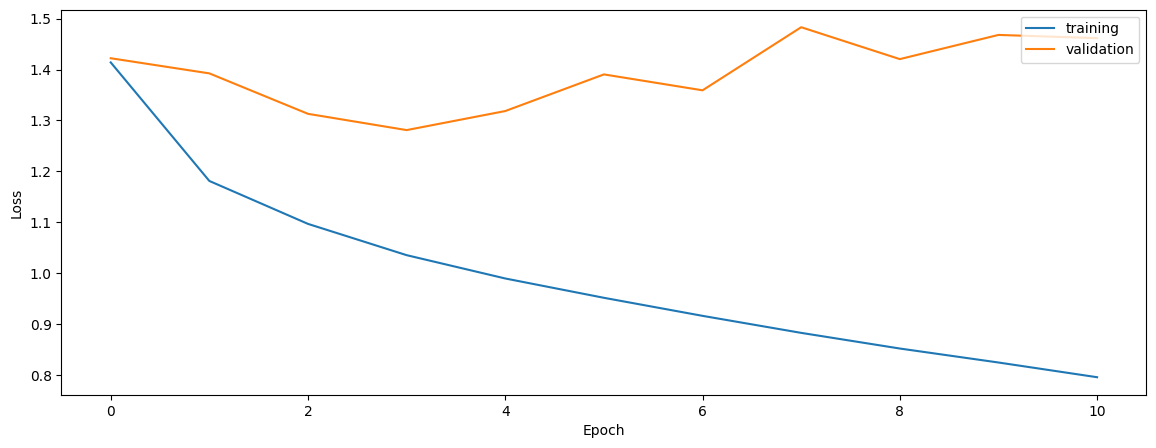

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6106340075437712
0.5186160422120419
0.4947359358472929


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.573918892727252
0.5582029324790537
0.5282850337435491


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5838877161888
0.5622589917969572
0.5568212308217675


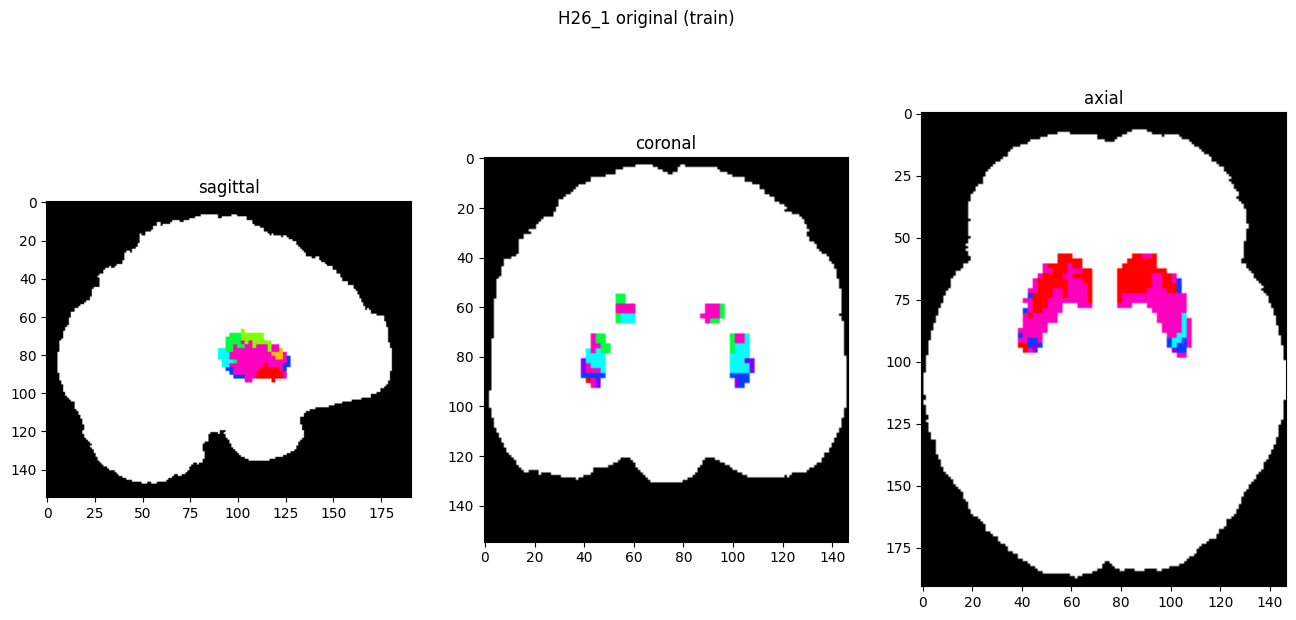

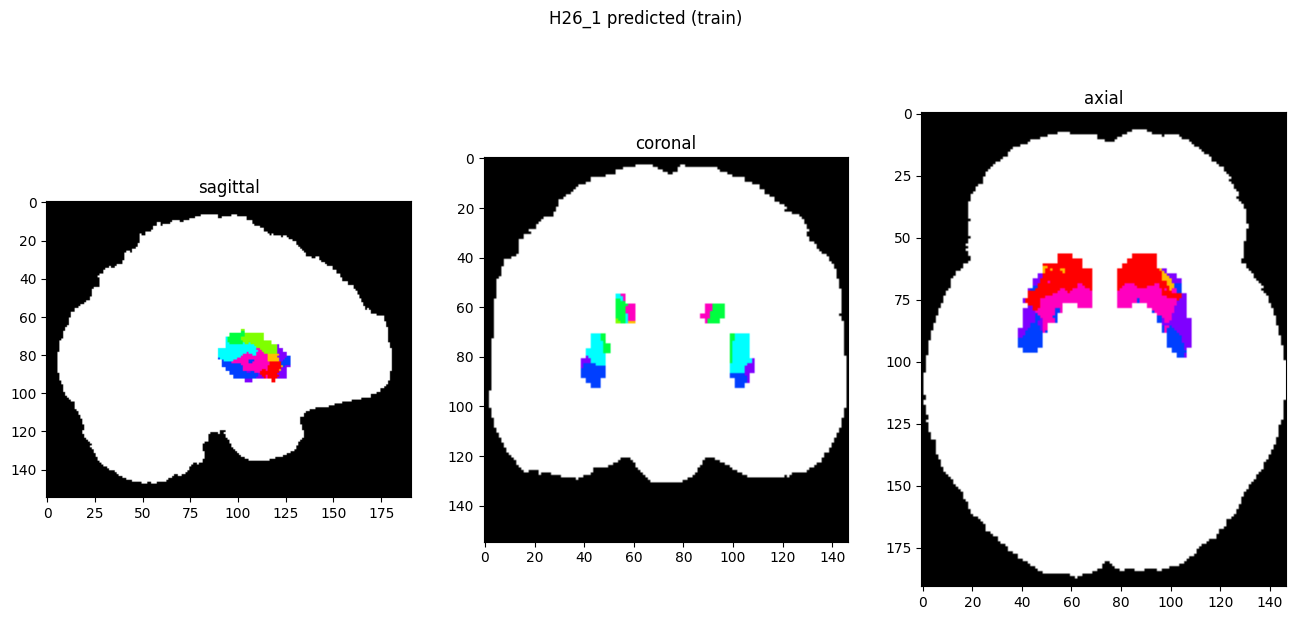

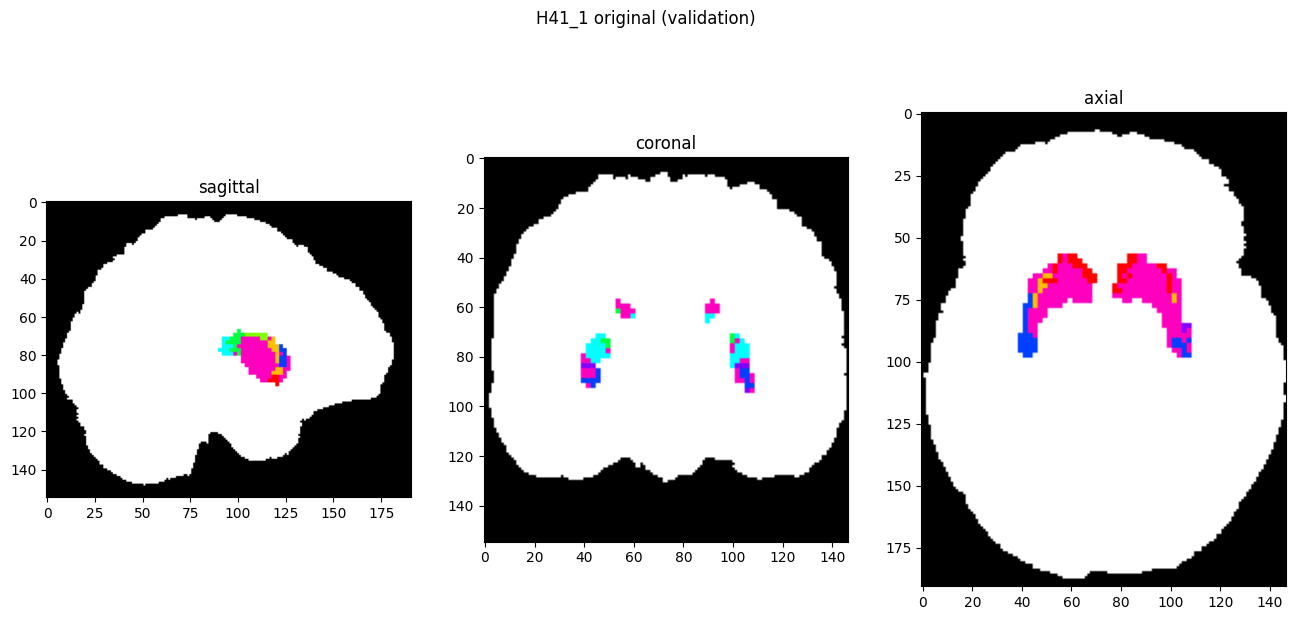

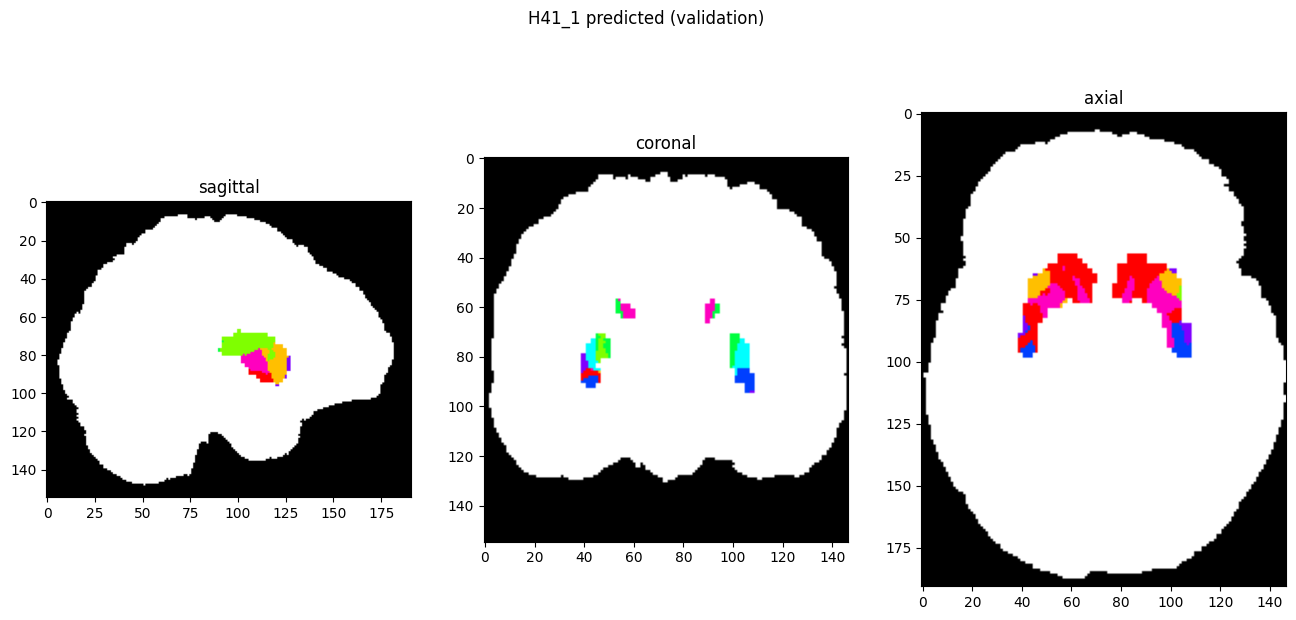

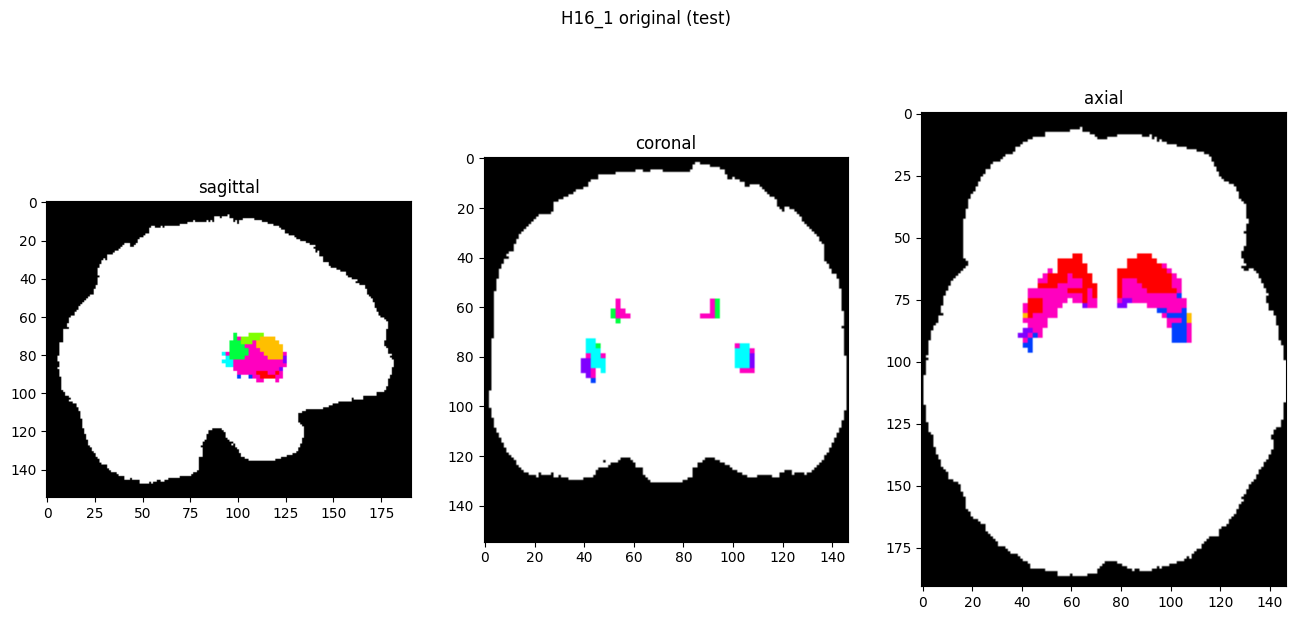

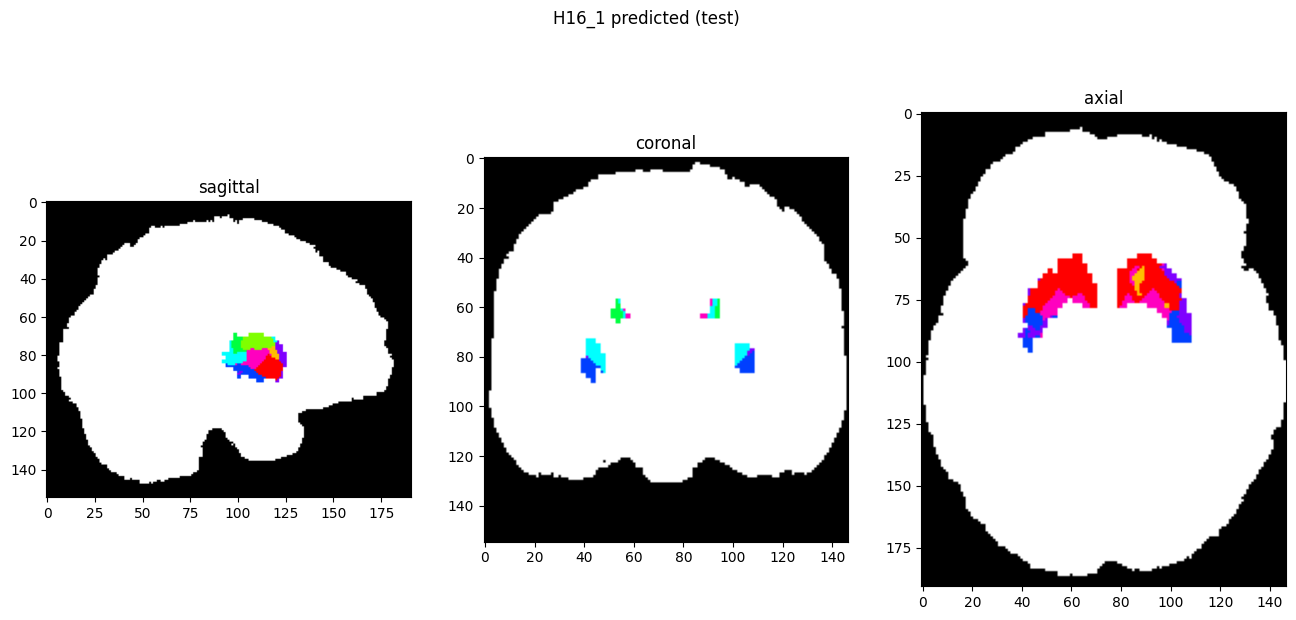

In [10]:
showResults(model, gen, threshold=0)